In [89]:
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 500)
az.style.use('arviz-darkgrid')

In [ ]:
df = pd.read_csv('../data/raw/train.csv')

- Applying visualisations as part of a principled statistical workflow. 
- Model diagnostics and troubleshooting
- Practice justifying priors and attempt at multilevel modelling to capture structure and complex relationships in the data
- Not covered: Chain diagnostics and weak fit (models are quite simple, so unlkely to come into this problem unless priors are really weak)

## EDA and Transformations

Take the log of both sales price and lot area. There seems to be a more linear relatrionship between the log variables as opposed to the raw variables. 

In [ ]:
def z_std(x):
    z_score = (x - x.mean()) / x.std()
    return(z_score)

df['log_sales_price'] = np.log(df['SalePrice'])
df['log_lot_area'] = np.log(df['LotArea'])

df['log_sales_price_z'] = z_std(df[['log_sales_price']])
df['log_lot_area_z'] = z_std(df[['log_lot_area']])

df['log_sales_price_std'] = df['log_sales_price']/df['log_sales_price'].mean()

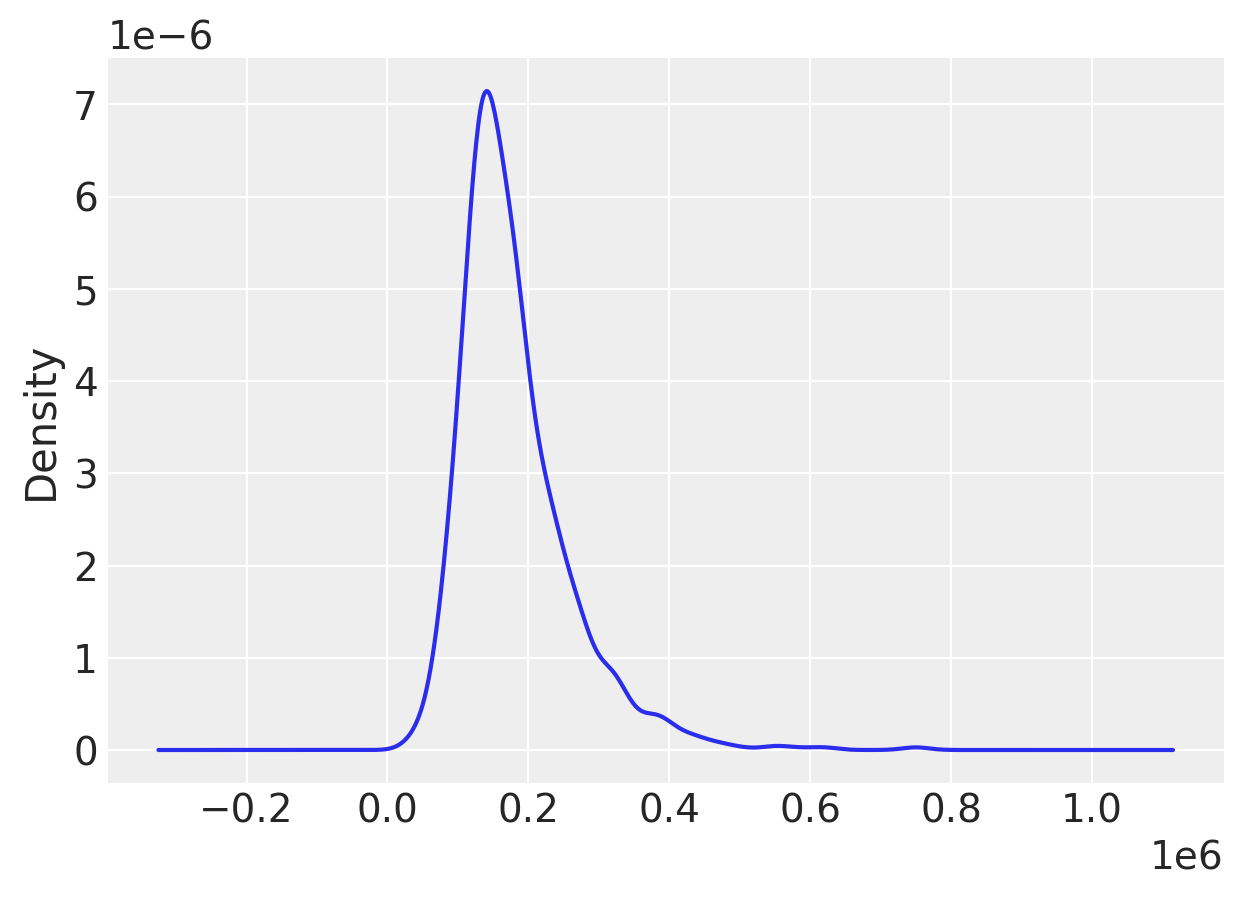

In [398]:
df['SalePrice'].plot.kde()

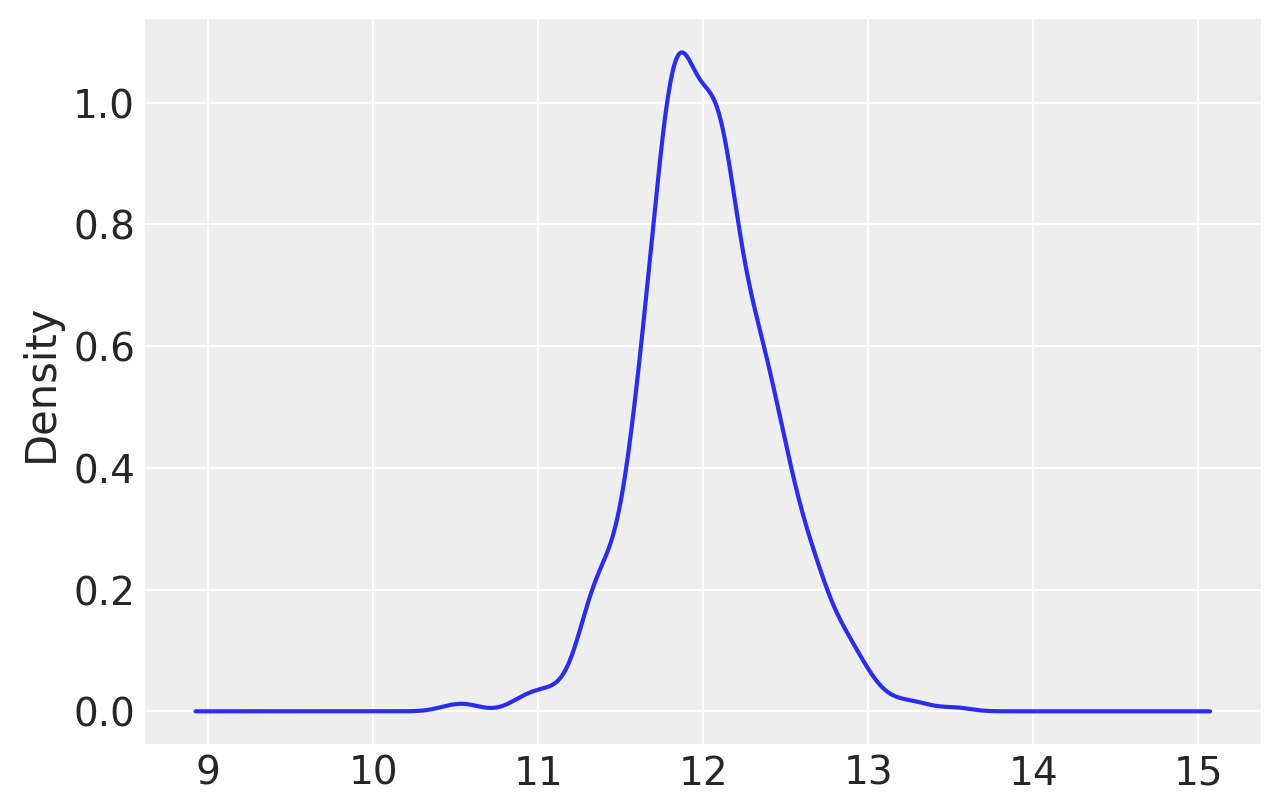

In [46]:
np.log(df['SalePrice']).plot.kde()

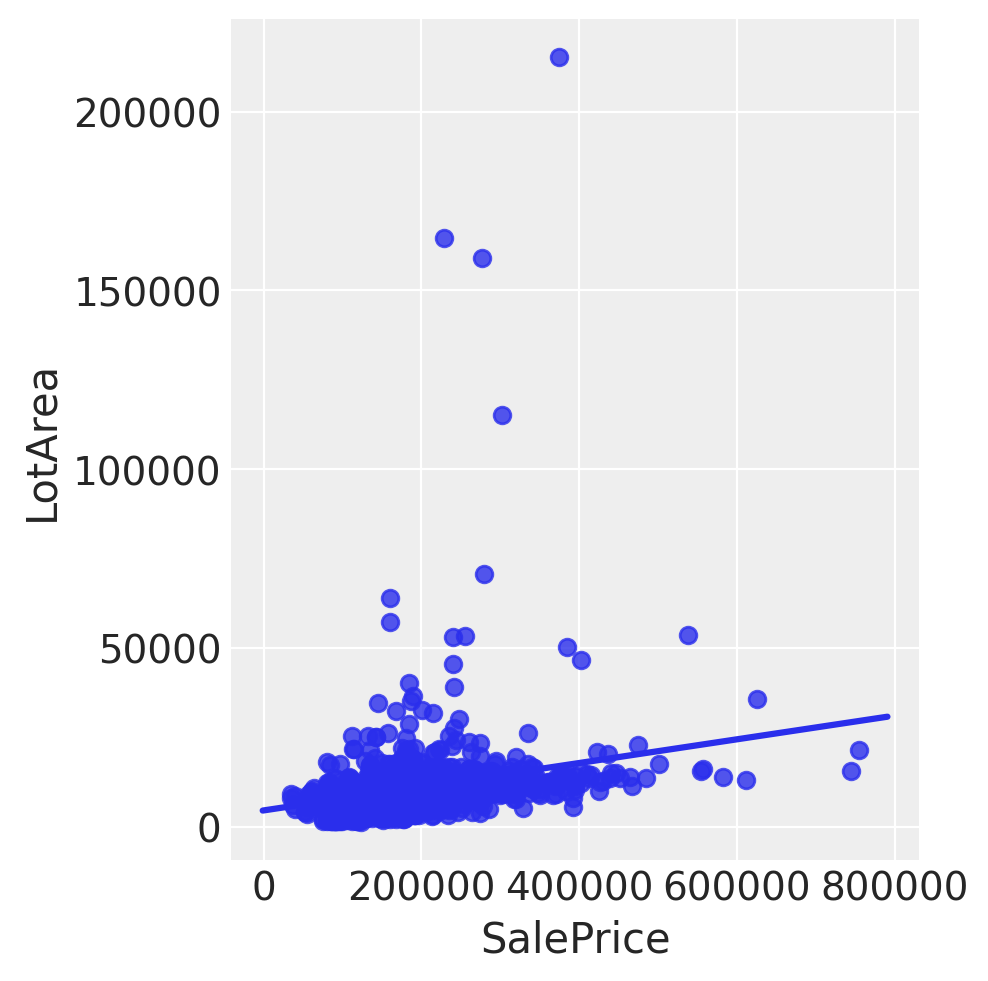

In [16]:
# Naive OLS with log transforms performs better than OLS on the raw scale. However, as always there seems to be some
# confounding in this relationshop that can be revealed by including more variables. 
sns.lmplot(x='SalePrice',y='LotArea',data=df,fit_reg=True) 

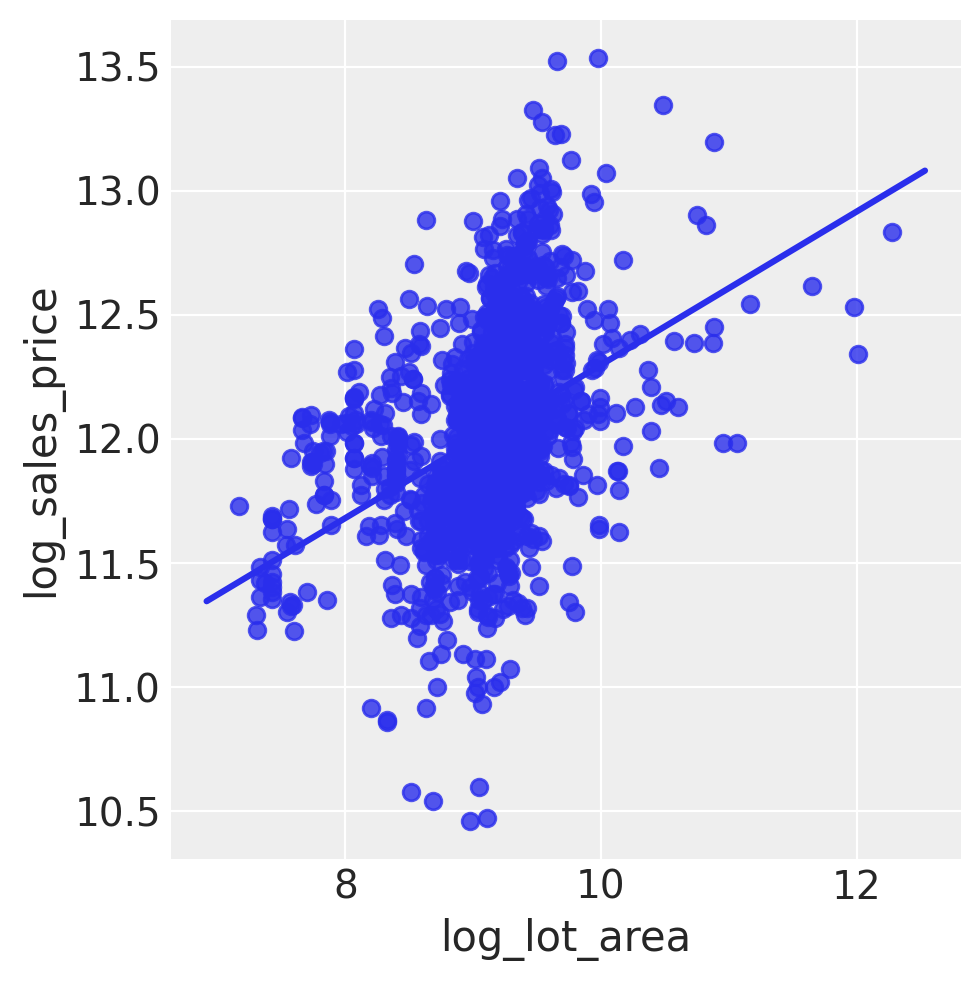

In [138]:
# Naive OLS with log transforms performs better than OLS on the raw scale. However, as always there seems to be some
# confounding in this relationshop that can be revealed by including more variables. 
sns.lmplot(x='log_lot_area',y='log_sales_price',data=df,fit_reg=True, ci = False) 

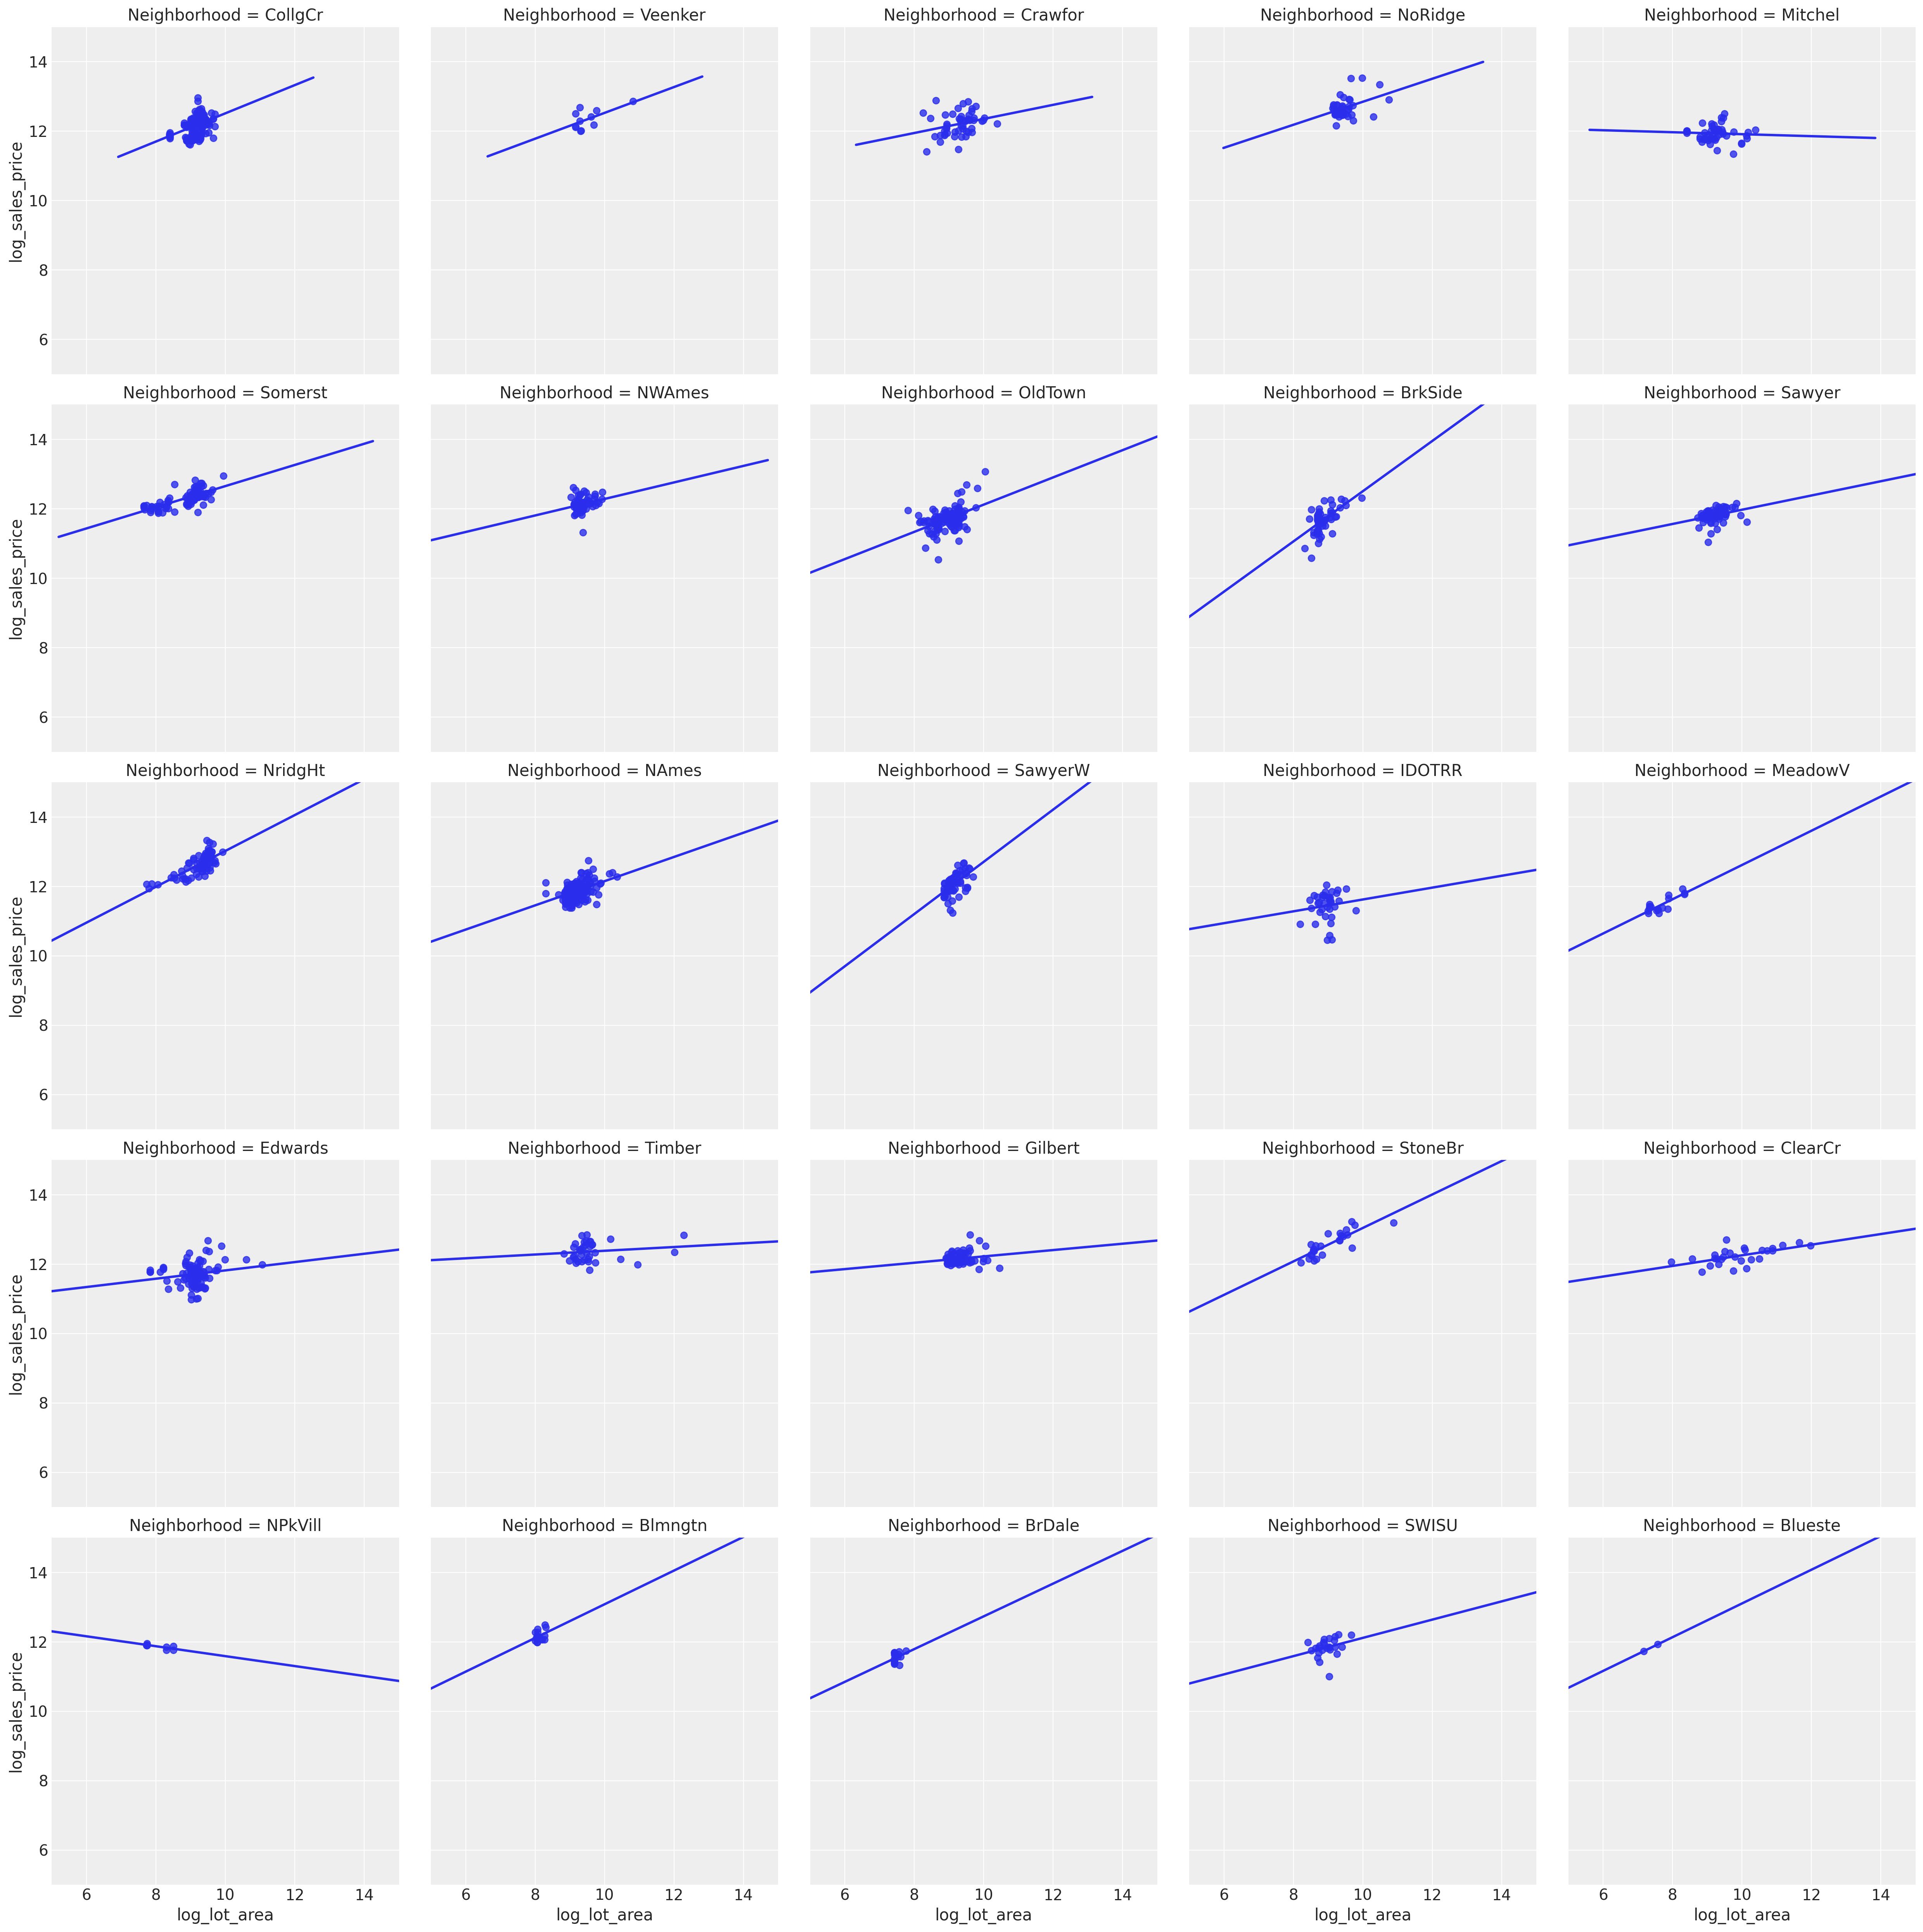

In [140]:
# Adding neighbourhood index/categorical variable shows varying intercepts and slope.
# There is clear structure and heterogeneity salesprice that should be modelled. 
# I will model this with two kinds of multilevel models: varying intercepts and random intercepts + slopes
g = sns.lmplot(x="log_lot_area", 
            y="log_sales_price", 
            col="Neighborhood",
            col_wrap = 5,
            data=df,
            ci = None)

g.set(xlim=(5, 15))
g.set(ylim=(5, 15))

## Model Definition

Let's start with simple linear model between $log(SalesPrice)_i$ and $log(LotArea)_i$. First, we want to standardise our outcome and predictor variables. This will make it easier to assign priors for parameters and in turn make it easier to sample from the posterior.  It will also help produce model outputs that are more interpretable. The model before standardisation will look like:

$$
log(SalesPrice)_i \sim Normal(\mu_i, \sigma_i) \\
\mu_i = \alpha + \beta * log(LotArea)_i
$$

I will center and scale $log(LotArea)_i$ by subtracting the mean of $log(LotArea)_i$ and dividing it by the standard deviation. 

$$
log(LA)_i = \frac{log(LotArea)_i - \overline{log(LotArea)}}{\sigma_{log(LotArea)}}
 $$

This will help assign sensible priors on the intercept. Using unscaled predictors often results in the intercept being uninterpretable without the context of other model parameters. As a result, it is often highly correlated with the predictor coefficients and requires weak priors. The average value of the standardised variable becomes zero with standard deviation one. I can now interpret $\alpha$ as the mean outcome value when the predictors are at their average, now zero.

I will divide $log(SP)_i$ by its mean value. The will make the average value of the outcome variable to be mean 1. Since SalePrice is on the log scale, a value of 1.1 for scaled $log(SP)_i$ can be interpreted as 10\% higher relative to the average value. 0.7 similarly can be interpreted as 70\% of the average value.

$$
log(SP)_i = \frac{log(SalesPrice)_i}{\overline{log(SalesPrice)}}
$$

## Selecting priors

Without looking too closely at the data, I do not have much context or domain expertise in this dataset. My expertise in housing prices in this part of the world is basically zero, which makes this quite a naive analysis. I do have some baseline belief about the nature of housing prices, since I do have some information about housing prices in Australia which may generalise overseas (always positive, usually positively correlated with the size of land, varies with location and socio-economic status). But nothing substantial about this context that will really add any informative priors to the model. Despite my lack of domain knowledge, I can still choose sensible priors that at least regularlise model results and are within the plausible outcome space.

Standardising the variables above makes it easier for me to choose weakly informative and regularising priors. I know that $\alpha$ is the average value of $log(SP)_i$ when $log(SP)_i$ is at its sample mean. So I expect the value of $\alpha$ to be near 1, which is the sample mean of $log(SP)_i$. 

For $\beta$ we want to assign weakly informative priors to hedge against overfitting. $\beta=0$ implies that on average, there is no association between sales price and lot area. Without much prior information I want to shrink $\beta$ closer towards zero. These distributions represents beliefs before data is observed. So all we really want to do is to assign probability to all plausible values, with less weight on extreme relationships. 

For now, I will select the following specification for my priors:

$$
\alpha\sim N(1, 0.5) \\
\beta\sim N(0, 0.5) \\
\sigma\sim exp(1)
$$

I have choosen a weak exponential prior for $\sigma$, which is defined over positive reals. I purposefully chose this to observe what happens when we choose a more diffuse prior for the variance. The perform prior predictive checks in the next section will determine whether our priors are reasonable and we can adjust them accordingly. The full model can be written out as:

$$
log(SP)_i \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha + \beta * log(LA)_i \\
\alpha\sim Normal(1, 0.5) \\
\beta\sim Normal(0, 0.5) \\
\sigma\sim exp(1)
$$



<!--
overfitting—impossibly large effects should be assigned low
prior probability—and also to force ourselves to think about what the model means.

 Choosing a gaussian prior centered at zero puts equal probabilistic weight on both negative and positive values. This goes against the intuition I have about lot or land size and property prices. I would expect a positive relationship between price and lot size in most cases, assuming all else equal.


### Log scale


### Centered variables

$$
\frac{log(SP)_i - \overline{log(SP)}}{\sigma_{log(SP)}} = \alpha + \beta * \frac{log(LA)_i - \overline{log(LA)}}{\sigma_{log(LA)}} + \epsilon_i
$$

Why have we standardised the dependent variable as well? 

So by standaridisng all variables, it makes it easier for me to choose weakly informative and regularising priors. The prior I will use for $\alpha$ and $\beta$ will be centred at zero. For alpha this means I that I expect the value of the outcome to be its mean when the predictors are at their mean value. For $\beta$, I want tight priors to regularise the relationship between prices and land size so that the model does not overlearn from the sample.

I will check the implication of these prior choices in my prior predictive checks. I expect distributions of log housing prices to be centred at mean 0 with the majority of probability mass to be within 2 standard deviations of the mean - which should be within the plausible regions of the outcome space.

### How to interpret coefficients?

Scaled log variables take a bit more work when it comes to interpreting coefficients. If beta equals 1, a 1 standard deviation increase in log lot area would be associated with a 1 standard deviation increase in log sales price. But how do you interpret a one standard deviation change on the log scale? In this case, a 1 standard deviation increase in log lot area is 1.677. This is approximately a 67.7% incrase in lot area. This would imply in our example a 1.49 increase in log sales price (remember beta is 1), so approximately a 49\% increase in sales price. This relationship seems quite strong so I would expect most of the beta probability  -->



## Model Definition

Let's start with simple linear model. Both $log(SP)_i$ and $log(LotArea)_i$ are standardised to mean zero and standard deviation 1. The intercept $\alpha$ can now be interpreted as the average value of log(salesprice) when log(lotarea) is at it's mean value (zero). Due to centering, the mean of the dependent variable $log(SP)_i$ is 0.

### Log scale
$$
log(SP)_i = \mu_i + \epsilon_i = \alpha + \beta * log(LA)_i + \epsilon_i \\
\epsilon\sim Normal(0, \sigma)
$$


### Centered variables

$$
\frac{log(SP)_i - \overline{log(SP)}}{\sigma_{log(SP)}} = \alpha + \beta * \frac{log(LA)_i - \overline{log(LA)}}{\sigma_{log(LA)}} + \epsilon_i
$$

Why have we standardised the dependent variable as well? Without looking too closely at the data, I do not have much context or domain expertise in this dataset. My expertise in housing prices in this part of the world is basically zero, which makes this quite a naive analysis. I do have some baseline belief about the nature of housing prices (always positive, usually positive with the size of land ceteris paribus, varies with location and socio-economic demography), but nothing to inform the design of the models and prior choice.

So by standaridisng all variables, it makes it easier for me to choose weakly informative and regularising priors. The prior I will use for $\alpha$ and $\beta$ will be centred at zero. For alpha this means I that I expect the value of the outcome to be its mean when the predictors are at their mean value. For $\beta$, I want tight priors to regularise the relationship between prices and land size so that the model does not overlearn from the sample.

I will check the implication of these prior choices in my prior predictive checks. I expect distributions of log housing prices to be centred at mean 0 with the majority of probability mass to be within 2 standard deviations of the mean - which should be within the plausible regions of the outcome space.

### How to interpret coefficients?

Scaled log variables take a bit more work when it comes to interpreting coefficients. If beta equals 1, a 1 standard deviation increase in log lot area would be associated with a 1 standard deviation increase in log sales price. But how do you interpret a one standard deviation change on the log scale? In this case, a 1 standard deviation increase in log lot area is 1.677. This is approximately a 67.7% incrase in lot area. This would imply in our example a 1.49 increase in log sales price (remember beta is 1), so approximately a 49\% increase in sales price. This relationship seems quite strong so I would expect most of the beta probability  



In [483]:
#np.std(df['log_lot_area'])
#df['SalePrice'].mean()
#df['SalePrice'].max()
#np.std((df['LotArea']))
#np.std((df['LotArea'] - np.mean(df['LotArea'])))
#
# Approx 67% increase in lot area is a 1 standard deviation change in log lot area
#np.exp(np.std(df['log_lot_area']))
#
## 1 standard deviation increase in log sales price is approximately at 49% increase in sales price.
#np.exp(np.std(df['log_sales_price']))
#
#So $\beta = 1$ implies that a one standard deviation increase in log lot area (about 67\%) is associated with a 49\% increase in sales price relative to the mean.
#np.exp((df['log_sales_price_z'] * df['log_sales_price'].std()) + df['log_sales_price'].mean())

## Fit the model and run prior predictive checks

In [484]:
ols = pystan.StanModel(file = '../src/models/linear_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_001c2fe5f1096c852711f85b63392b99 NOW.


In [5]:
# Fake data for checking
lot_area_fake = np.arange(-2, 3, 4)
len(lot_area_fake)

2

In [486]:
data = dict(N = len(df),
           log_sales_price = df['log_sales_price_std'],
           log_lot_area = df['log_lot_area_z'],
           x_new = lot_area_fake,
           N_new = len(lot_area_fake),
           alpha_sd = 0.5,
           beta_sd = 0.001,
           run_estimation = 0)

fit_ols = ols.sampling(data=data)
ols_df = fit_ols.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


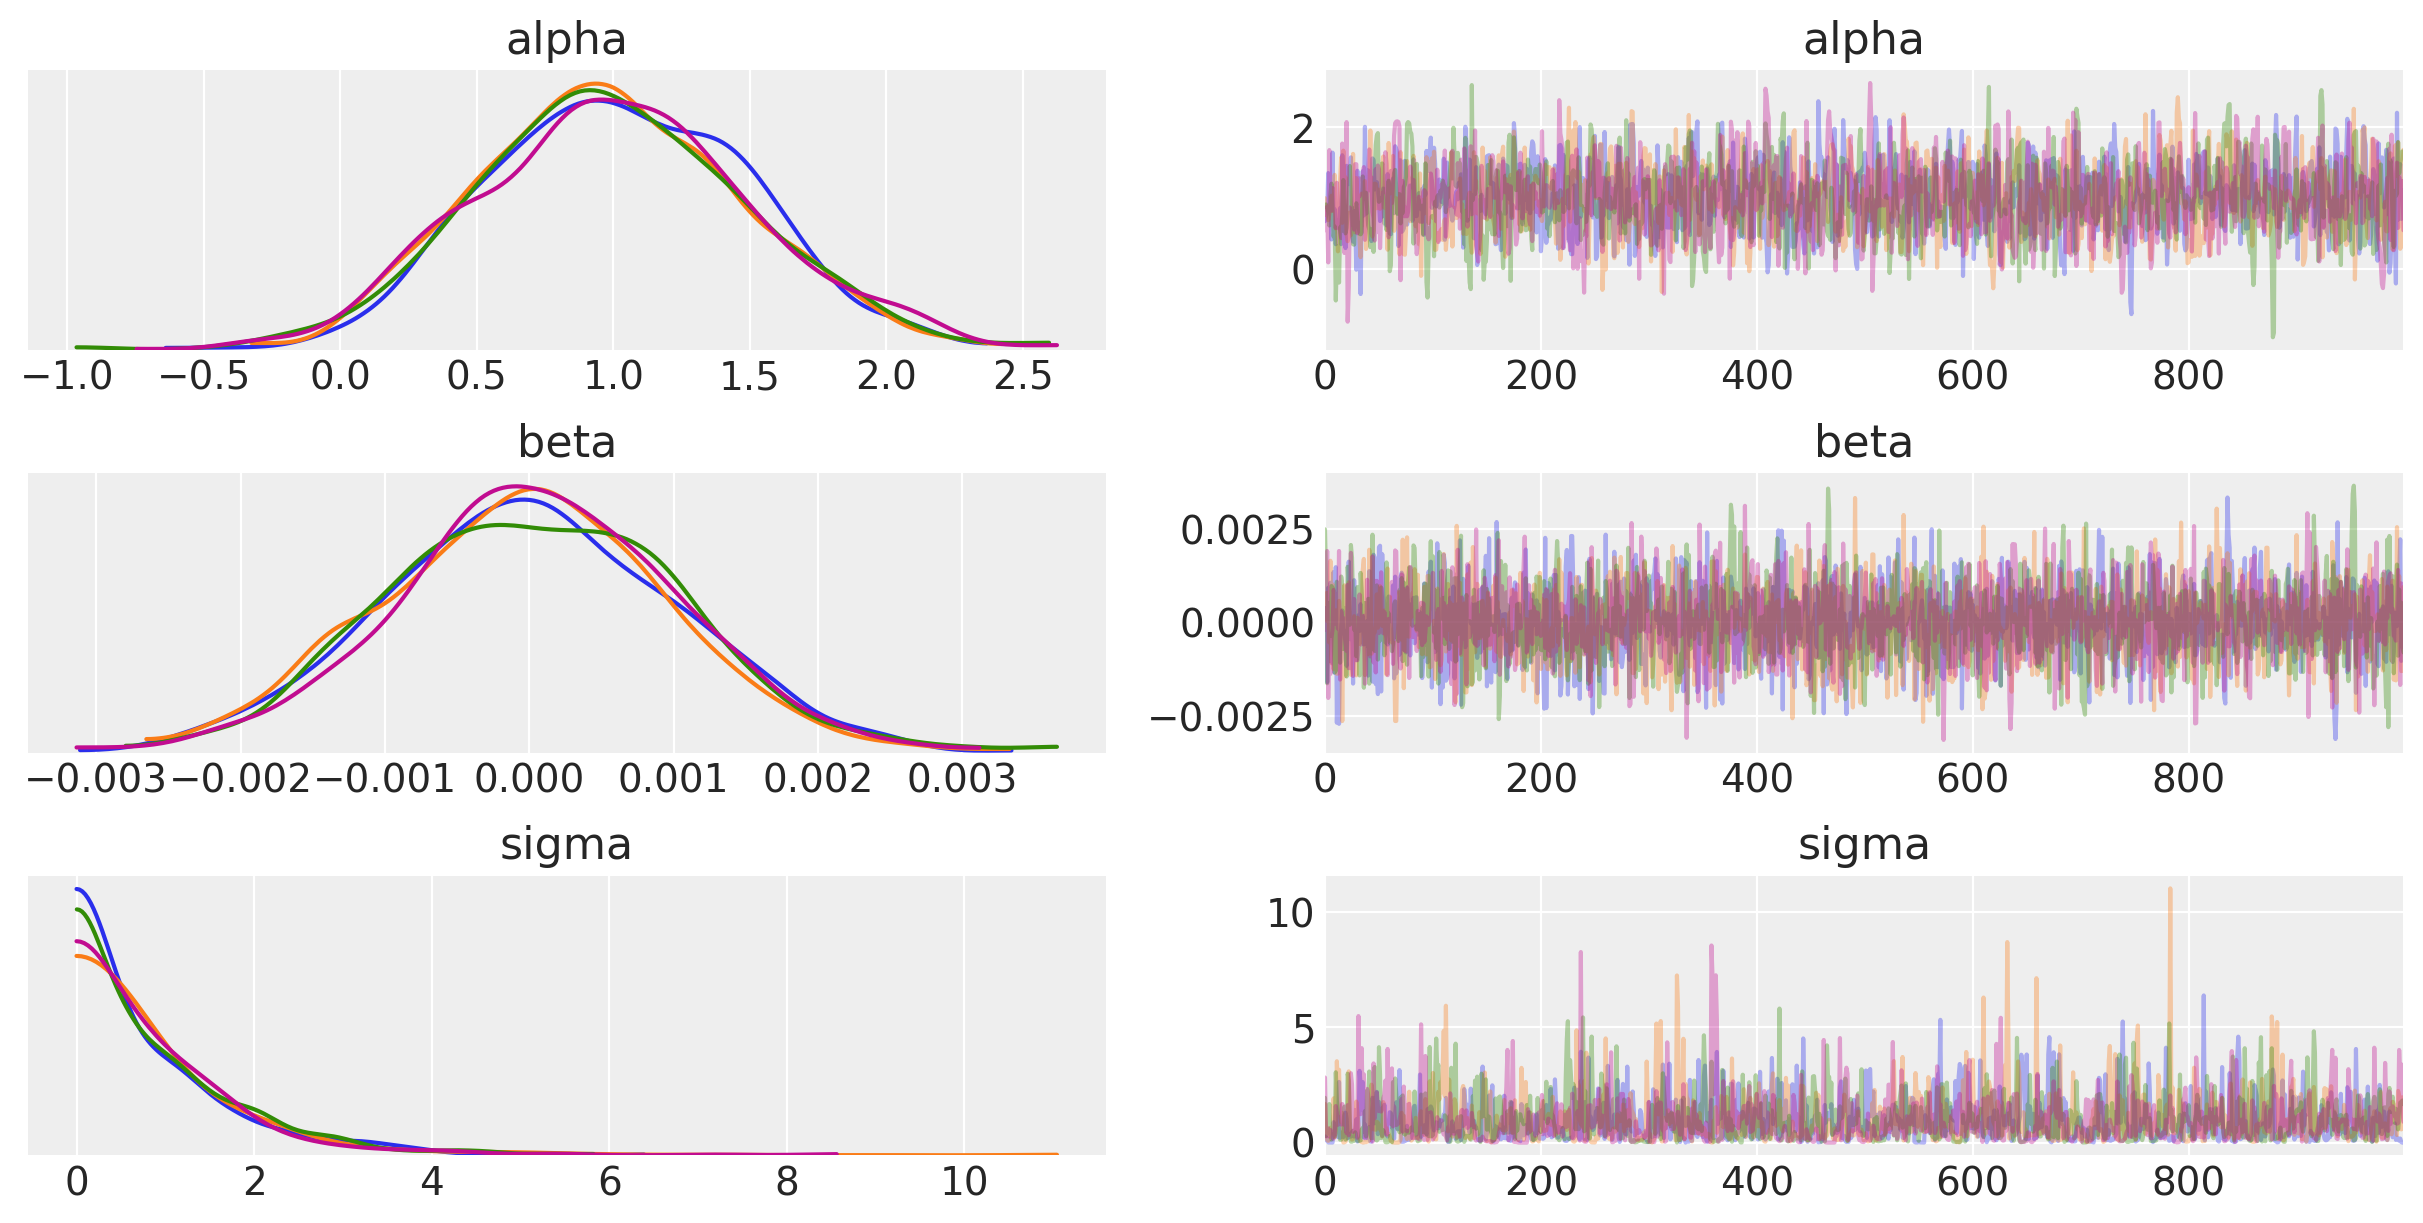

In [487]:
#az.summary(fit_ols, var_names=["alpha", "beta", "sigma"], credible_interval=0.89)
az.plot_trace(fit_ols, var_names=["alpha", "beta", "sigma"], compact = True);

## Prior Predictive Checks and fake data simulation

We expect outcomes of the standardised house prices to be within 2 standard deviations of the mean and the location of distributions to be centred close to one. 

Let's see what happens when we choose uninformative, flat priors for both the intercept and slope by setting the scale parameter to 10. Below are distributions from 100 parameter draws from our priors.

In [80]:
pd.set_option('min_rows', -1)
#pd.DataFrame(np.exp(np.random.normal(0,0.5,100)*df['log_sales_price'].mean())).head(100)

In [499]:
flat_data = dict(N = len(df),
           log_sales_price = df['log_sales_price_std'],
           log_lot_area = df['log_lot_area_z'],
           x_new = lot_area_fake,
           N_new = len(lot_area_fake),
           alpha_sd = 10,
           beta_sd = 10,
           run_estimation = 0)

fit_flat_ols = ols.sampling(data=flat_data)
ols_flat_df = fit_flat_ols.to_dataframe()



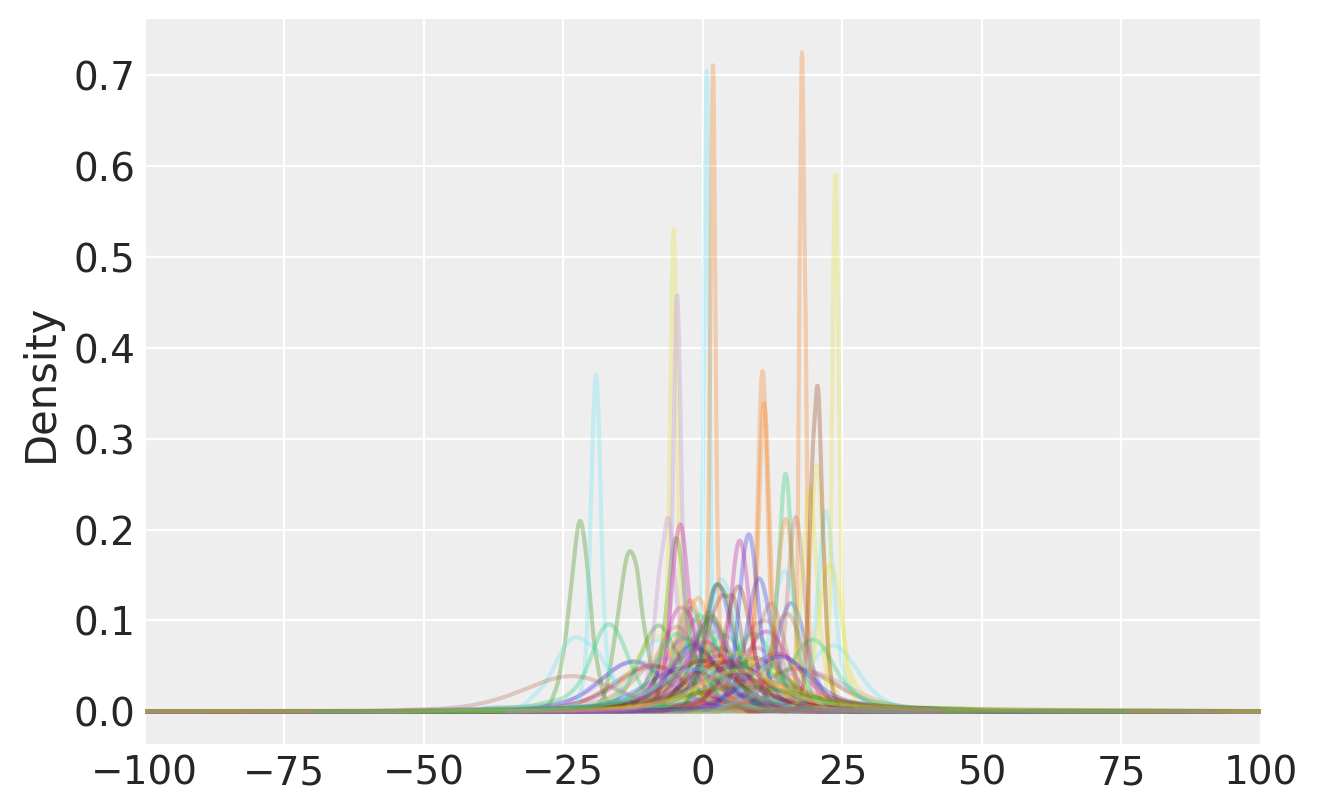

In [502]:
ols_flat_df.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (-100, 100));

This does not make sense at all. This says that our expectations of housing prices vary wildly between -30 and 30 (remember, a 0.1 increase implies 10\% greater than the average housing price) before we have seen the data. Let's select some tighter priors for our parameters and see the results

In [84]:
weak_data = dict(N = len(df),
           log_sales_price = df['log_sales_price_std'],
           log_lot_area = df['log_lot_area_z'],
           x_new = lot_area_fake,
           N_new = len(lot_area_fake),
           alpha_sd = 0.5, # try 1 and 1
           beta_sd = 0.5, # 95% of probability between 100% increases of the mean after 1 sd increase in lot area
           run_estimation = 0)

fit_weak_ols = ols.sampling(data=weak_data)
ols_weak_df = fit_weak_ols.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


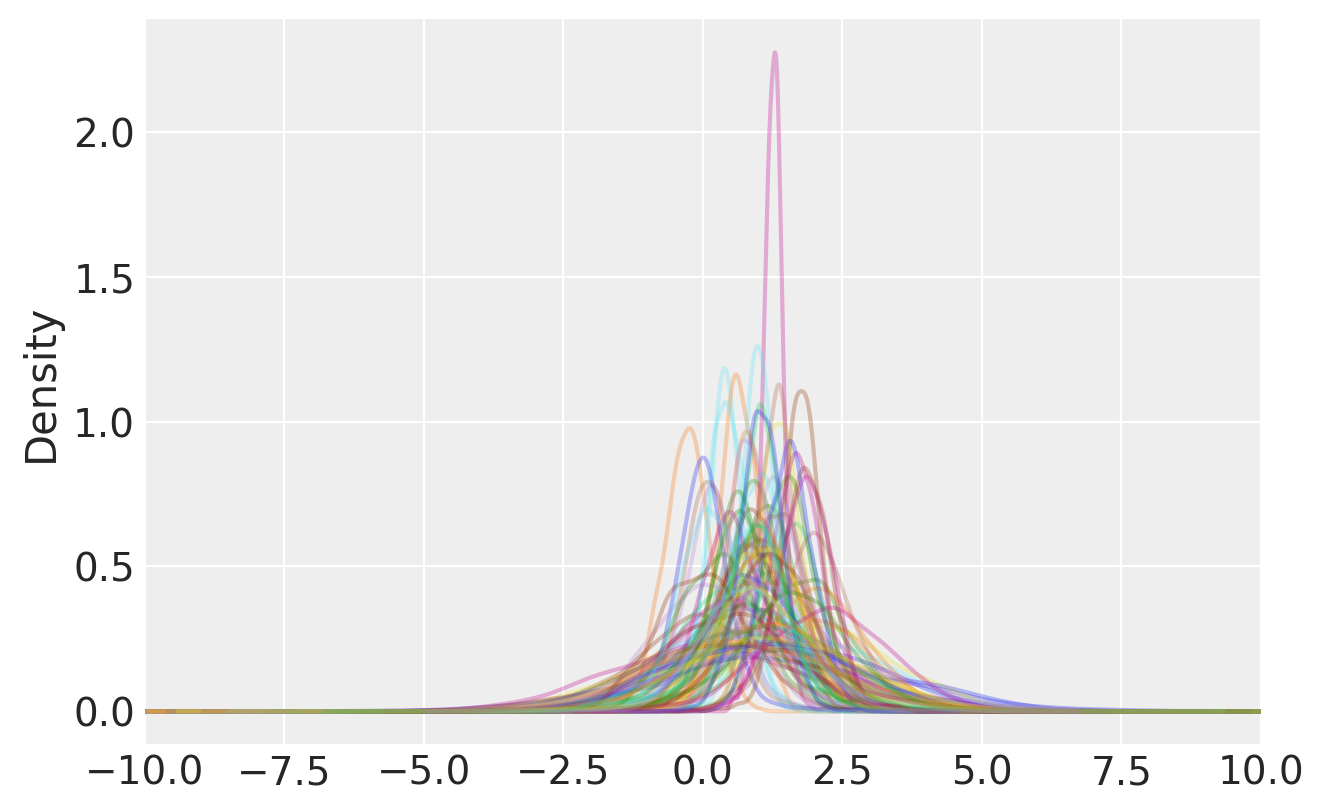

In [85]:
ols_weak_df.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (-10, 10));

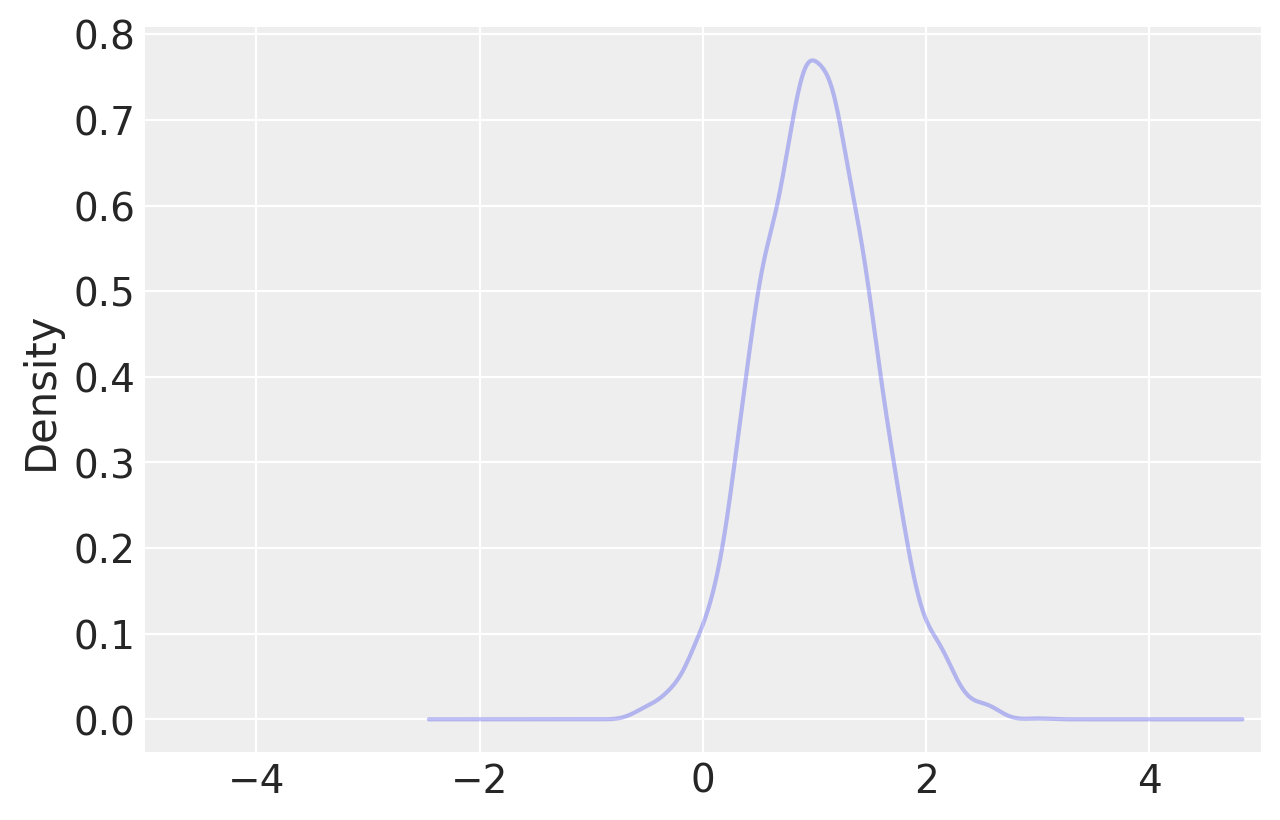

In [86]:
ols_weak_df.filter(regex = 'y_hat').T.mean(axis = 0).plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (-5, 5));

This is better. The prior densities are within what I expect to be more plausible ranges of expected housing prices. We can interrogate the choice of these priors further by looking at the implied intercept and slopes.

<Figure size 720x480 with 0 Axes>

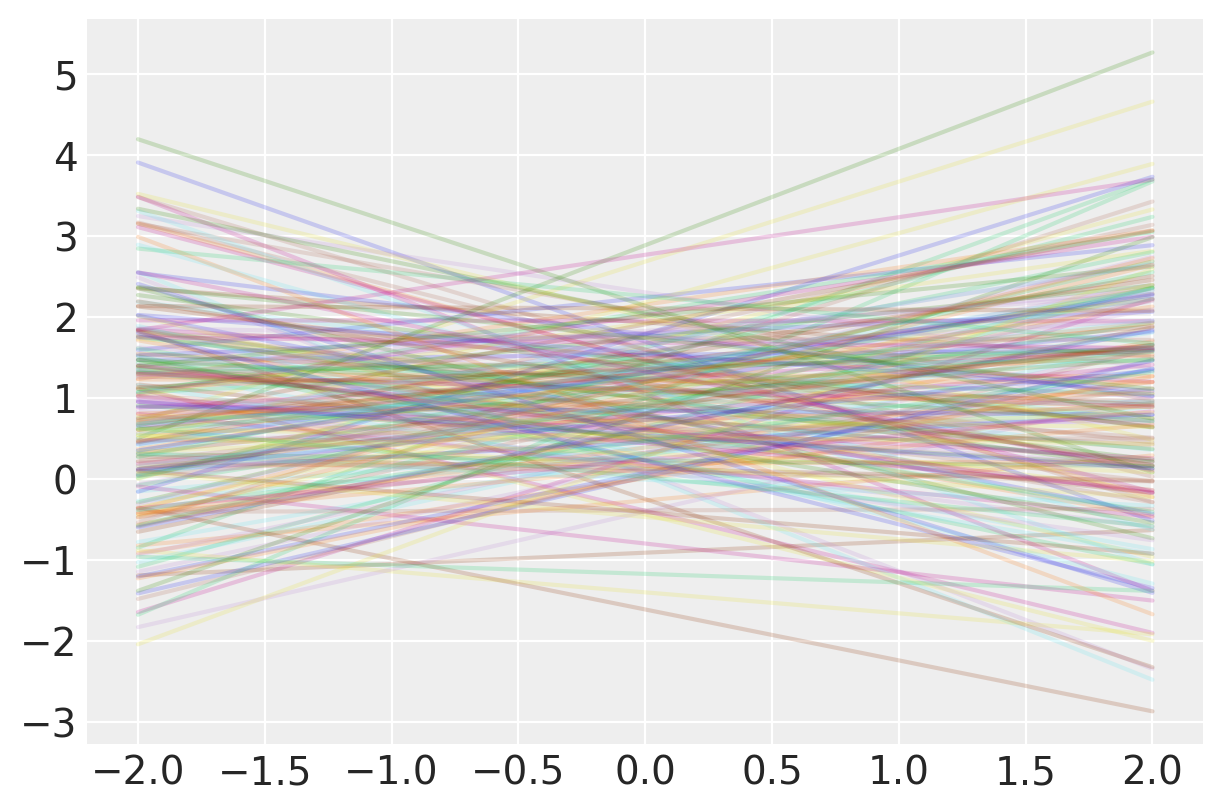

In [88]:
y_new_sample = ols_weak_df.filter(regex = 'y_new')\
                     .T\
                     .iloc[:, :200]\
                     .reset_index()\
                     .drop('index', axis = 1)

y_new_sample.index = lot_area_fake

plt.figure();
y_new_sample.plot(legend = False, alpha = 0.2);

## Other candidate models

It may be worth considering some other models we can apply this workflow to before estimating the simple OLS model to data. This will enable us to do some model comparison at the end and consider some other relevant variables. 

The initial EDA showed that there is probably some heterogeneity in the relationship between sales price and lot area between neighbourhoods. We can add dummy variables and interaction terms to the model to capture some of these neighbourhood effects. 

Adding dummy variables assumes that the effects of each neighbourhood are _independent_ of each other. The model does not learn anything by about prices in other neighbourhoods after observing the prices in any particular neighbourhood. This is a pretty big assumption -- it seems sensible to assume that housing prices share a closer relationship to adjacent neighbourhoods rather than those further away. This will suffice for now as we want to start with simple models to practice this workflow. The next post on multilevel models will alleviate the assumption of independence between neighbourhoods.

Below is the specification of the dummy variable model - where we take the neighbourhood variable and create a binary outcome for each neighbourhood as each column. Instead of creating the dummy variables ourselves, we can input neighbourhood as an index variable in Stan. Note that we include _all_ neighbourhoods as part of the index and drop the intercept. If we include the intercept, the model assigns extra uncertainty to the category which is not used as a dummy variable, and assigns extra uncertainty to its estimation (alpha + beta distributions).

$$
log(SP)_i \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha_{NH[j]} + \beta * log(LA)_i \\
\alpha_j\sim Normal(1, 0.5),\space for\space j = 1...J\space neighbourhoods\\
\beta\sim Normal(0, 0.5) \\
\sigma\sim exp(1)
$$

Lastly, we add interactive terms between neighbourhood and lot area. This captures associations of sales price with lot area conditional on the neighourhood. However, a weakness of this approach is that the model on its own does not have any context of the interaction. While the above is a more 'natural' interpretation, it can also be interpreted as the association of sales price with neighbourhood conditional on lot area. Or how does the association of sales price with neighbourhood depend on lot area? This is a valid interpretation of the interactive term. Thankfully, this is not a _causal_ analysis, nor a causal model. But it's always good practice to consider what the specified model implies about the associations between variables. 

$$
log(SP)_i \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha_{NH[j]} + \beta_{NH[j]}  * log(LA)_i \\
\alpha_j\sim Normal(1, 0.5),\space for\space j = 1...J\space neighbourhoods\\
\beta_j\sim Normal(0, 0.5) \\
\sigma\sim exp(1)
$$

Note that we could specify the above models by explicitly writing out the dummy variables and interactions:

$$
\mu_i = \alpha_{NH[1]}x_{NH[1]} + \alpha_{NH[2]}x_{NH[2]} + \dots +\alpha_{NH[J]}x_{NH[J]} + \\ \beta_{log(LA), x[1]} * log(LA)_i * x_1 + \beta_{log(LA), x[2]} * log(LA)_i * x_2 + \beta_{log(LA), x[J]} * log(LA)_i * x_J \\
$$

Where $x$ is a dummy variable for the Jth neighbourhood. As you can see, writing the above out would be necessary and prone to writing and coding errors (we would have to set the priors for each dummy variable and interaction separately). Using the index variables above is much more tidy and allows us to specify the same prior for the slopes irrespective of the neighbourhood.

> Stan code here

Below are the prior predictive checks for all three models:

In [ ]:
Amd

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


<Figure size 720x480 with 0 Axes>

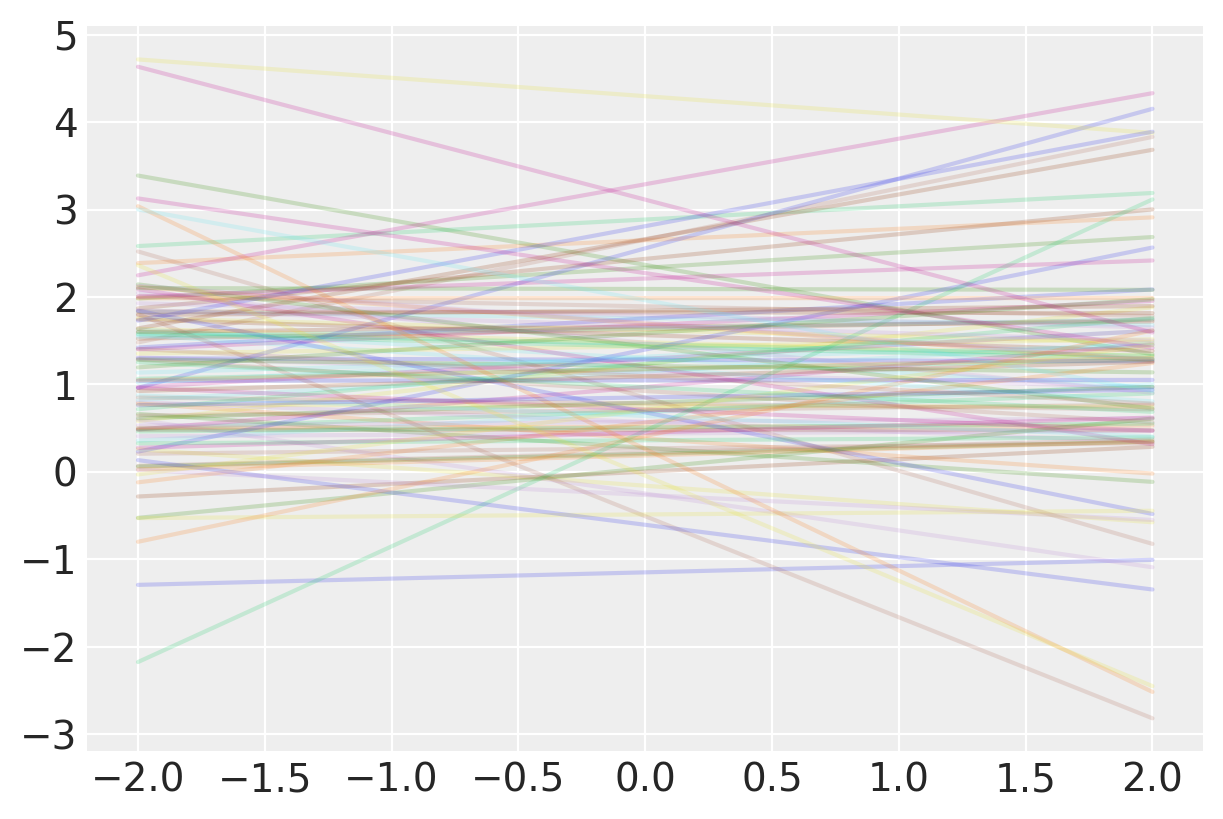

In [516]:
ols = pystan.StanModel(file = '../src/models/linear_model.stan')

data = dict(N = len(df),
           log_sales_price = df['log_sales_price_std'],
           log_lot_area = df['log_lot_area_z'],
           x_new = lot_area_fake,
           N_new = len(lot_area_fake),
           alpha_sd = 1,
           beta_sd = 1,
           run_estimation = 0)

fit_ols = ols.sampling(data=data)
ols_df = fit_ols.to_dataframe()

y_new_sample = ols_df.filter(regex = 'y_new')\
                     .T\
                     .iloc[:, :100]\
                     .reset_index()\
                     .drop('index', axis = 1)

y_new_sample.index = lot_area_fake

plt.figure();
y_new_sample.plot(legend = False, alpha = 0.2);

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8fb92168b1f02ade7281d0f54dc67627 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


<Figure size 720x480 with 0 Axes>

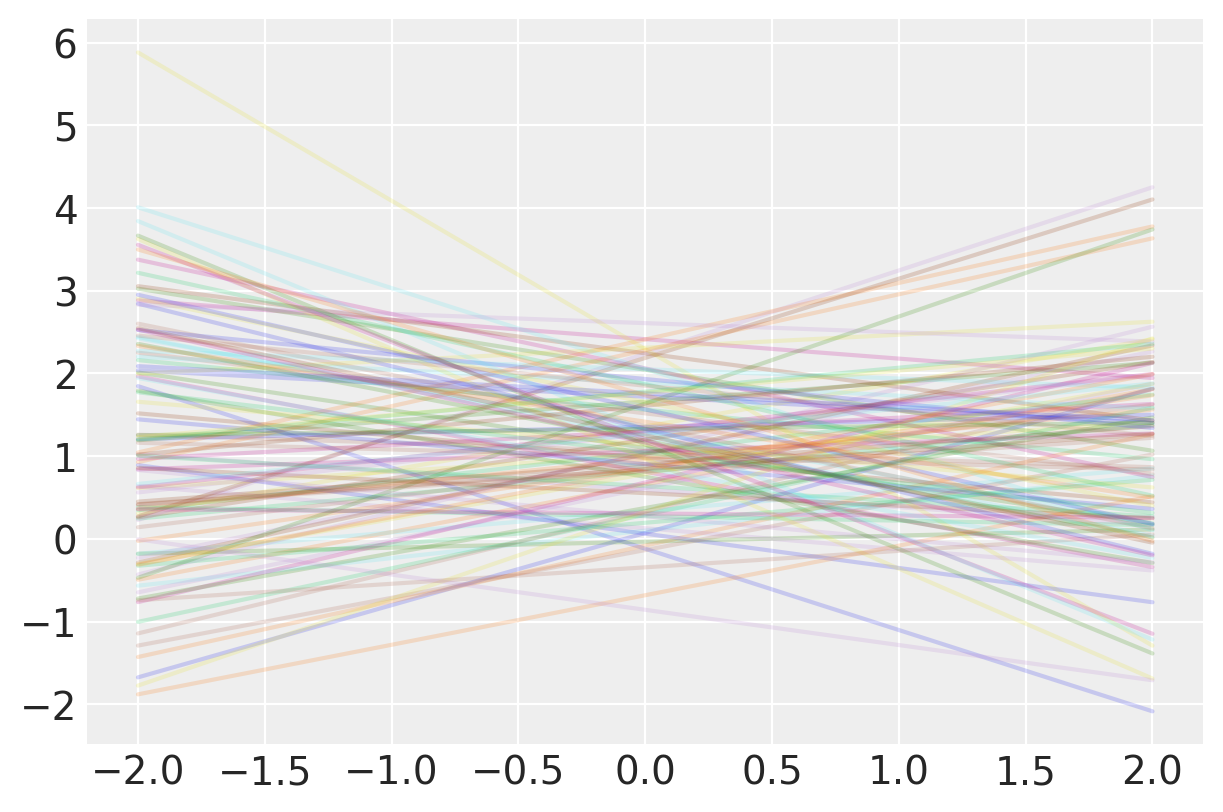

In [68]:
ols = pystan.StanModel(file = '../src/models/linear_model.stan')
data = dict(N = len(df),
           log_sales_price = df['log_sales_price_std'],
           log_lot_area = df['log_lot_area_z'],
           x_new = lot_area_fake,
           N_new = len(lot_area_fake),
           alpha_sd = 0.5,
           beta_sd = 0.1,
           run_estimation = 0)

fit_ols = ols.sampling(data=data)
ols_df = fit_ols.to_dataframe()

y_new_sample = ols_df.filter(regex = 'y_new')\
                     .T\
                     .iloc[:, :100]\
                     .reset_index()\
                     .drop('index', axis = 1)

y_new_sample.index = lot_area_fake

plt.figure();
y_new_sample.plot(legend = False, alpha = 0.2);

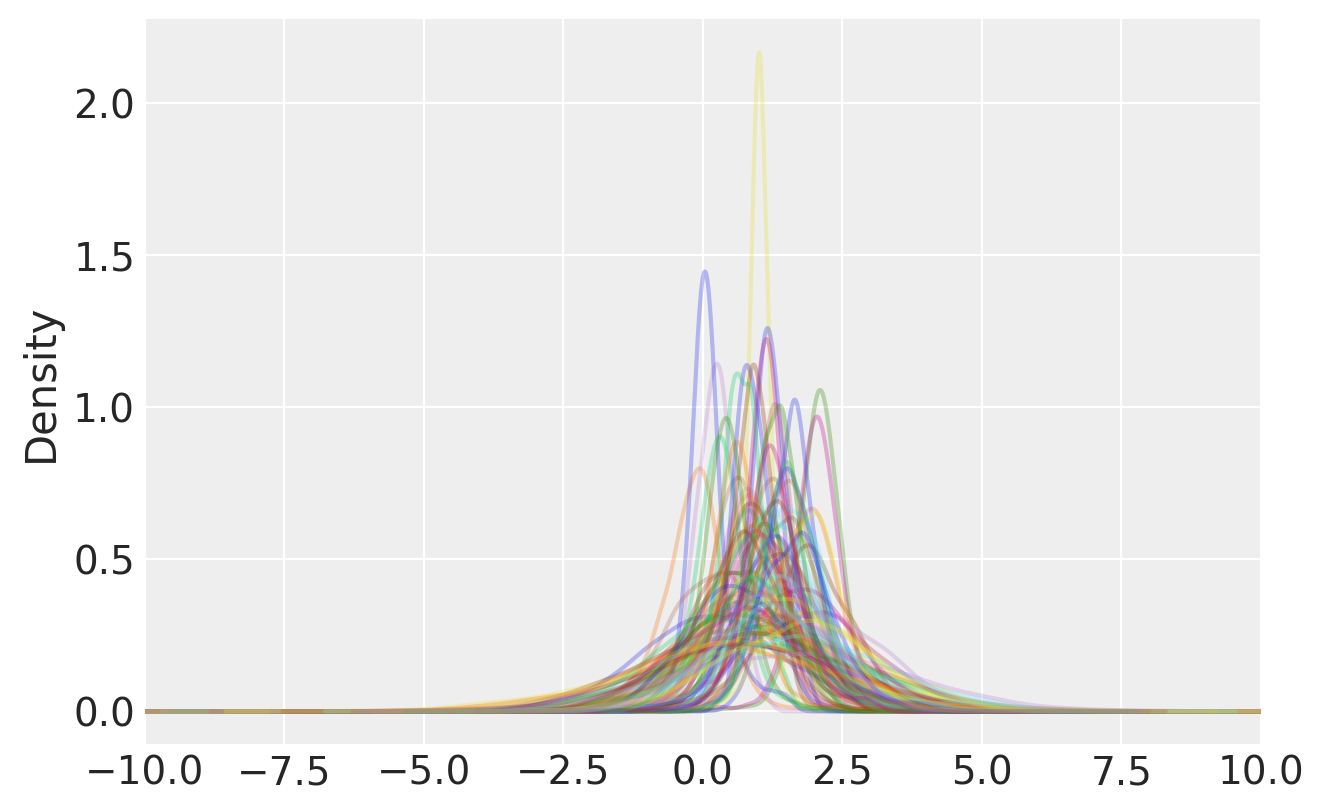

In [69]:
ols_df.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (-10, 10));

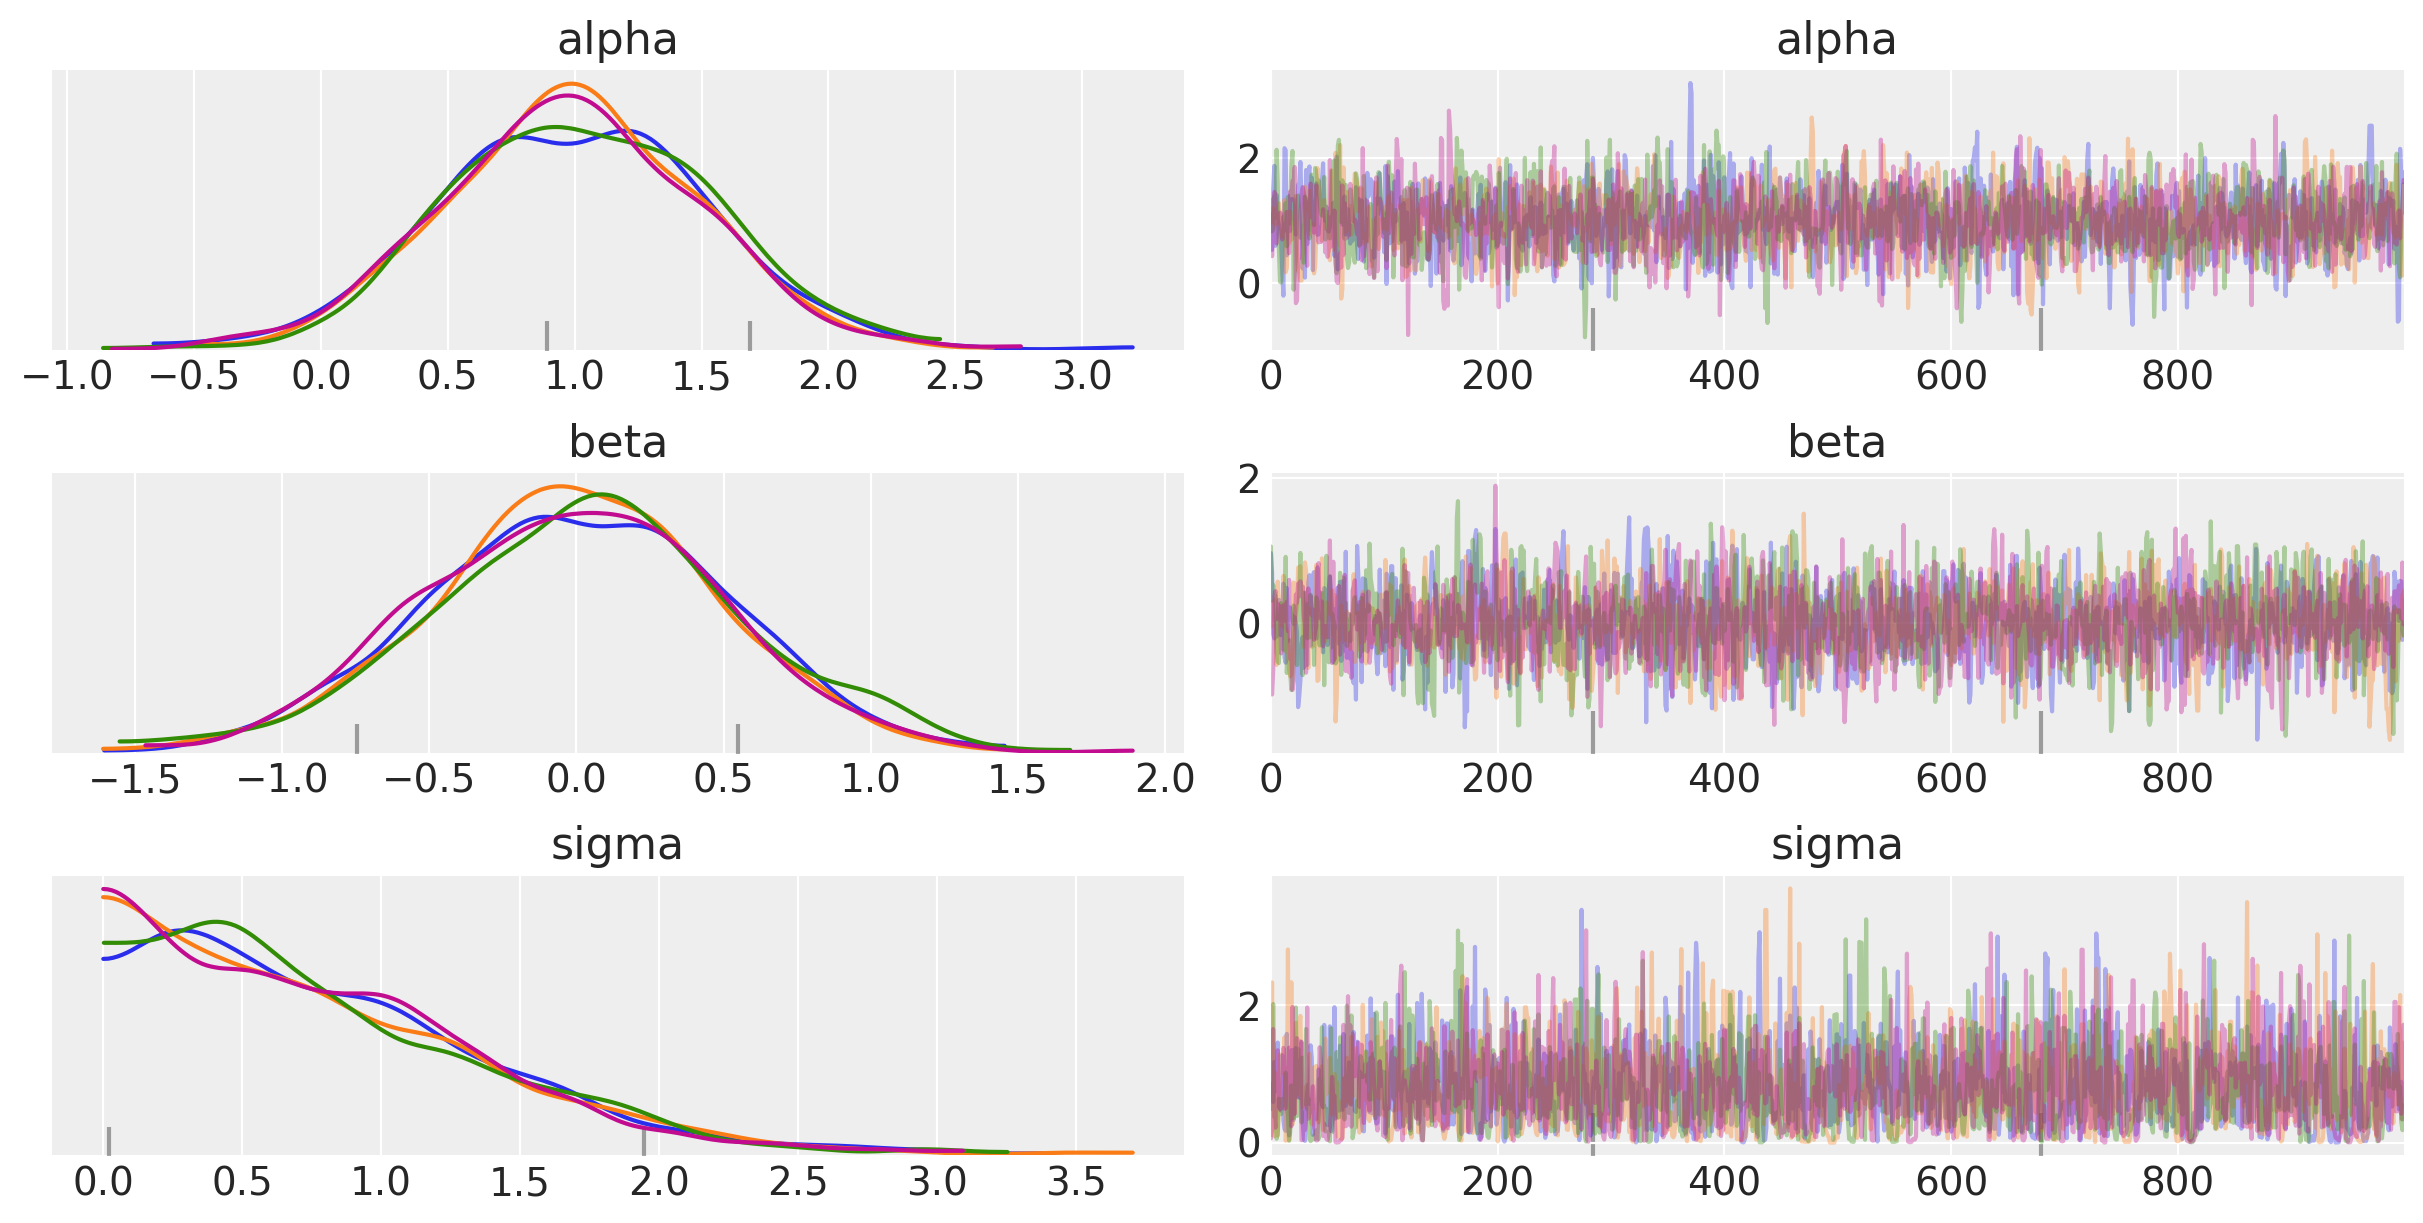

In [70]:
#az.summary(fit_ols, var_names=["alpha", "beta", "sigma"], credible_interval=0.89)
az.plot_trace(fit_ols, var_names=["alpha", "beta", "sigma"], compact = True);

In [67]:
pd.set_option('display.float_format', '{:.2f}'.format)
ols_df.filter(regex = 'y_hat')\
              .T\
              .iloc[:, :100]*df['log_sales_price']

0      1     2     3     4     5     6     7     8     9     \
y_hat[1]    12.39  12.50 16.22 11.33 13.32  7.97  9.70  8.77 14.79 13.27   
y_hat[2]     8.85  -5.96  9.94 12.64 15.53 12.29 15.33  3.58  9.81 14.78   
y_hat[3]    15.05  24.94 12.06 12.54 11.61 12.78 14.01  9.73 10.33 12.37   
y_hat[4]    -2.24  32.85 14.99 11.72 10.62 11.09 10.90 14.80 13.72 11.95   
y_hat[5]    -1.20 -10.77 15.08 16.26 13.87 20.27  7.15  0.90 18.43 14.42   
...           ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   
y_hat[1456] 12.00  -0.28 14.04 11.06 12.83  8.01  8.55  9.64 17.52 10.61   
y_hat[1457] 17.34   6.11 14.55 14.58 13.53 15.70 17.48 12.12 12.30 17.47   
y_hat[1458]  6.90  19.28 11.46 10.76 12.85  9.31 10.43 13.87 11.30 12.37   
y_hat[1459] 12.94  -7.06 15.29 13.24 13.54 11.58 11.16 15.19 11.00 12.85   
y_hat[1460] 17.75   7.40 12.04 13.14 12.58  9.71 14.22 -1.87  9.06 16.35   

             10    11    12    13    14    15    16    17    18    19    20    \
y_hat[1]    11.93 14.17  6.12 12.59 10.20 27.97  8.71 10.20 17.62 15.32 11.96   
y_hat[2]     2.69 15.12 17.00 20.64  8.60 20.33  4.26 12.38 16.98 10.30 23.81   
y_hat[3]    15.34 15.06 15.40  9.92 11.19 -1.77 11.41 13.60  8.83 11.48 13.44   
y_hat[4]     4.46 12.61 11.28  6.52  4.90  5.25 11.18 11.96  5.73  4.45 16.34   
y_hat[5]    12.70 16.64 10.93 11.68  7.77 10.87 19.71 15.04 -2.68 -0.71 19.28   
...           ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
y_hat[1456] 10.84 10.24  6.97 15.75 18.11 14.57 19.70 14.16 16.16 11.86 15.83   
y_hat[1457]  5.20 16.51  8.81 19.12 11.51 -1.88 18.49 12.71 20.11  5.54 28.84   
y_hat[1458] 12.82 14.77  7.26 19.45 12.68  8.98 13.80 14.58  8.86 14.65 15.72   
y_hat[1459]  4.46 13.34  5.51  4.27 11.42  7.47 15.86 10.81 10.86  8.22 18.53   
y_hat[1460]  3.80 13.40 11.55 12.77 11.40 -4.05 10.94 15.75 12.30  7.83 10.20   

             21    22    23    24    25    26    27    28    29    30    31    \
y_hat[1]     9.43 10.07 20.44 21.32 11.53  5.87 11.79 11.55 -7.47 18.71 18.38   
y_hat[2]     7.91 11.25 12.87  4.63 11.82  1.12  9.95 11.93 12.05 12.23 10.56   
y_hat[3]     9.22  8.80 16.92 11.69 14.52  5.35 16.76  9.23 -8.54  2.77 13.23   
y_hat[4]     9.92 13.22 14.26  8.88 11.06 17.49 10.68 13.12  4.68  9.88  3.15   
y_hat[5]     4.58  7.37 11.06  3.56  6.43  1.00 29.19  9.10 14.05  6.58 -8.18   
...           ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
y_hat[1456]  3.27 14.71  4.41 15.89 23.48 16.92 16.36 13.77 -0.71 15.16  5.04   
y_hat[1457]  6.82 12.68  5.50  7.95  2.91 13.18 33.74  6.46 16.34  4.04 21.03   
y_hat[1458]  1.61 15.03 12.80  9.14  4.63  3.67 10.21 12.35 11.71  6.67 39.59   
y_hat[1459]  8.54  6.17  8.54 20.64 27.73 14.58 24.10 12.01 19.01 13.68  3.92   
y_hat[1460] 13.85 12.40 20.12 12.31  7.07 15.44  0.05 12.88 11.87  6.23 30.20   

             32    33    34    35    36    37    38    39    40    41    42    \
y_hat[1]    13.02 13.27  9.37 15.65 12.30 12.41 11.56 11.69 12.77 17.09 20.20   
y_hat[2]    13.51 12.96 16.39 13.17 12.63 12.67 14.53 13.63 14.07 16.04 16.95   
y_hat[3]    11.02 13.40 13.92 14.89 12.43 13.69 16.75 14.76 18.85  4.79 13.97   
y_hat[4]    13.63 10.56 11.18 16.96 12.51 11.49 14.63 13.59 14.70 10.50 10.43   
y_hat[5]    12.16 11.49 20.92 18.08 15.32 12.80 22.08 18.21 27.97 -4.07 -0.99   
...           ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
y_hat[1456] 13.47 12.45  8.01 10.91  9.68 10.56 10.74 10.60 10.49 16.61 30.38   
y_hat[1457]  9.39 14.08 17.58 11.03 13.36 12.33 18.97 16.68 24.20  2.71  8.13   
y_hat[1458] 12.11 15.27 10.87 13.89 10.91 10.60 14.03 13.03 14.34 11.73 16.59   
y_hat[1459] 14.96 14.11 12.60 16.06 11.63 13.04 14.25 13.28 15.38 10.74 20.66   
y_hat[1460] 10.29 10.94 16.54 14.48 13.39 13.27 13.30 13.12 18.84  5.45  5.11   

             43    44    45    46    47    48    49    50    51    52    \
y_hat[1]    -1.87 10.95  9.42 16.79 15.37 14.15  7.53 14.50 15.15 -5.96   
y_hat[2]     3.12  7.12 14.63 1

In [71]:
pd.set_option('display.float_format', '{:.2f}'.format)
np.exp((ols_df.filter(regex = 'y_hat')\
              .T\
              .iloc[:, :100]*df['log_sales_price'].mean()).mean(axis=1))

y_hat[1]       664693.44
y_hat[2]       682905.32
y_hat[3]       811614.61
y_hat[4]       300099.63
y_hat[5]       191397.22
                 ...    
y_hat[1456]    331908.27
y_hat[1457]   4088261.36
y_hat[1458]   2546448.69
y_hat[1459]     89101.59
y_hat[1460]    346946.61
Length: 1460, dtype: float64

In [72]:
np.exp((ols_df.filter(regex = 'y_hat')\
              .T\
              .iloc[:, :100]*df['log_sales_price'].mean()).mean(axis=1)).describe()

count       1460.00
mean      823199.46
std      1222069.44
min        14108.75
25%       220356.72
50%       432564.22
75%       927491.61
max     17821425.49
dtype: float64

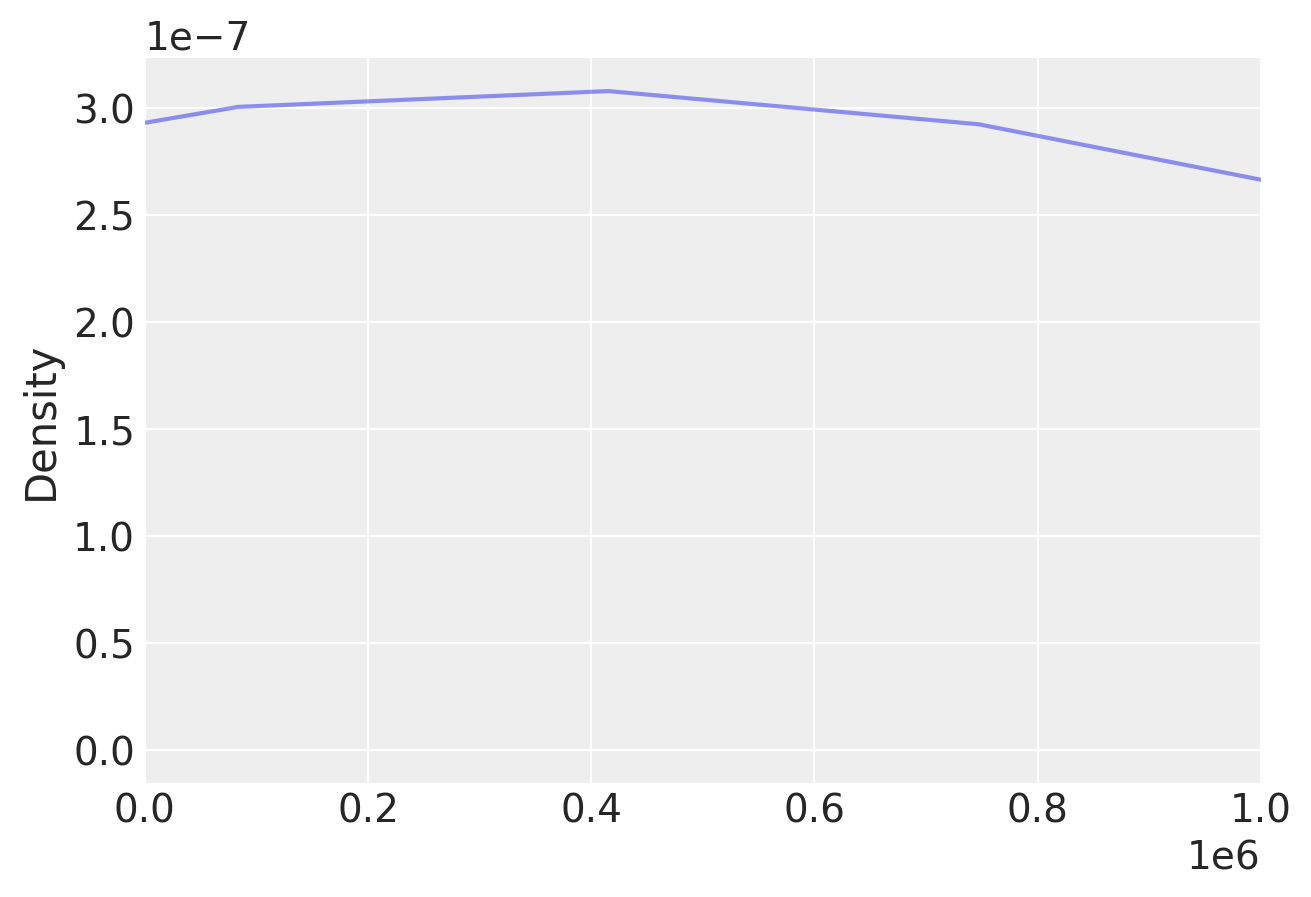

In [433]:
np.exp((ols_df.filter(regex = 'y_hat')\
              .T\
              .iloc[:, :100]*df['log_sales_price'].mean())\
              .mean(axis=1))\
              .plot.kde(alpha=0.5,
                        legend = False,
                        xlim=(0,1000000))

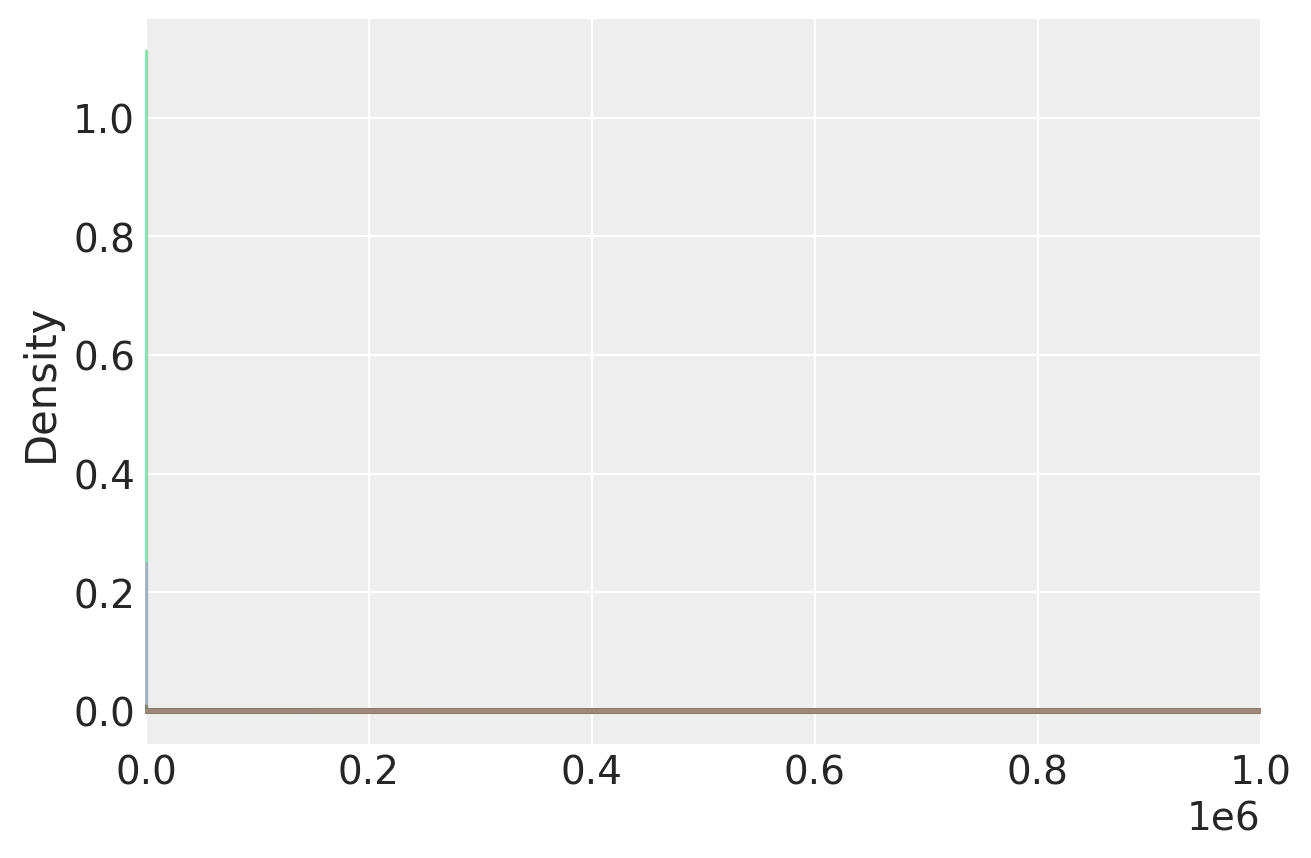

In [434]:
np.exp(ols_df.filter(regex = 'y_hat').T.iloc[:, :100]*df['log_sales_price'].mean()).plot.kde(alpha=0.5,
                                                        legend = False,
                                                        xlim = (-1000,1000000))

These results do not make sense at all. Remember, the outcome variable has been normalised to mean zero and standard deviation one. So we expect the mean of our fake data to be closer to zero than what appears here and approximately 95% of outcomes within two standard deviations of the mean. 

My prior choice should be predicting the majority of outcomes within the space of higher probability. We shouldn't be putting too much probabilistic weight on unlikely outcomes, nor should we be putting any weight onto _impossible_ values.

Let's try choosing weakly informative priors by reducing the scale from 10 to 1. Below we get slightly more sensible outcomes.

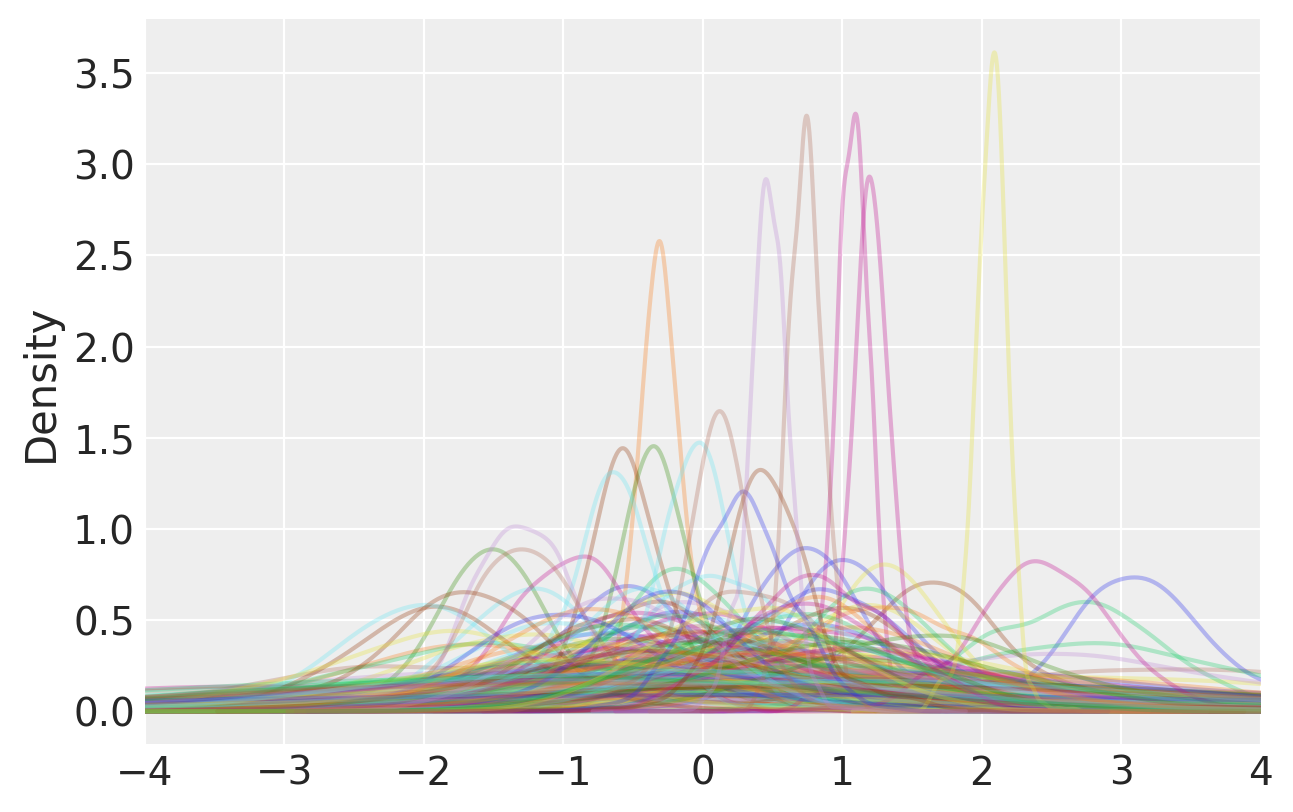

In [124]:
ols_df.filter(regex = 'y_hat').T.iloc[:, :200].plot.kde(alpha=0.3,
                                                        legend = False, xlim = (-4, 4));

That's better, but some of the distributions are not really within expectations. Another way of visualising the implications of our priors is by graphing the implied relationship between the predictor and dependent variables.

<Figure size 720x480 with 0 Axes>

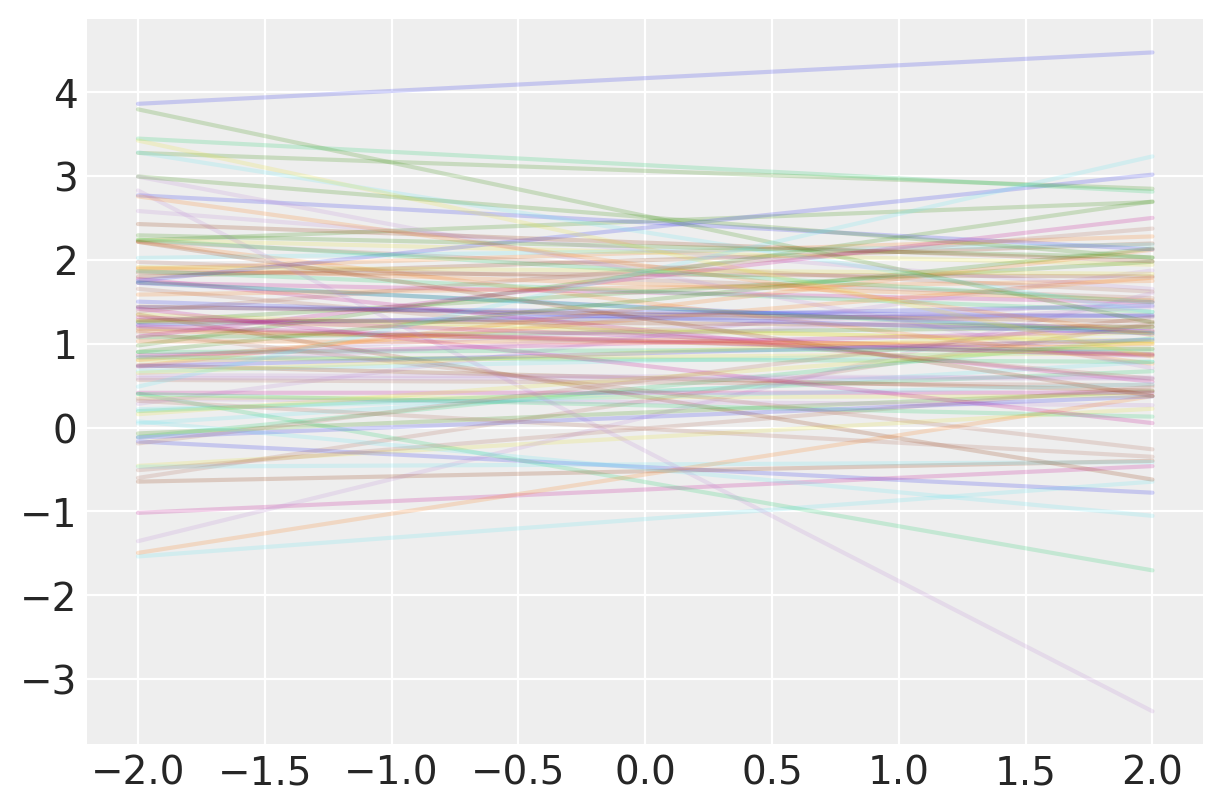

In [479]:
y_new_sample = ols_df.filter(regex = 'y_new')\
                     .T\
                     .iloc[:, :100]\
                     .reset_index()\
                     .drop('index', axis = 1)

y_new_sample.index = lot_area_fake

plt.figure();
y_new_sample.plot(legend = False, alpha = 0.2);

## Posterior predictive checks

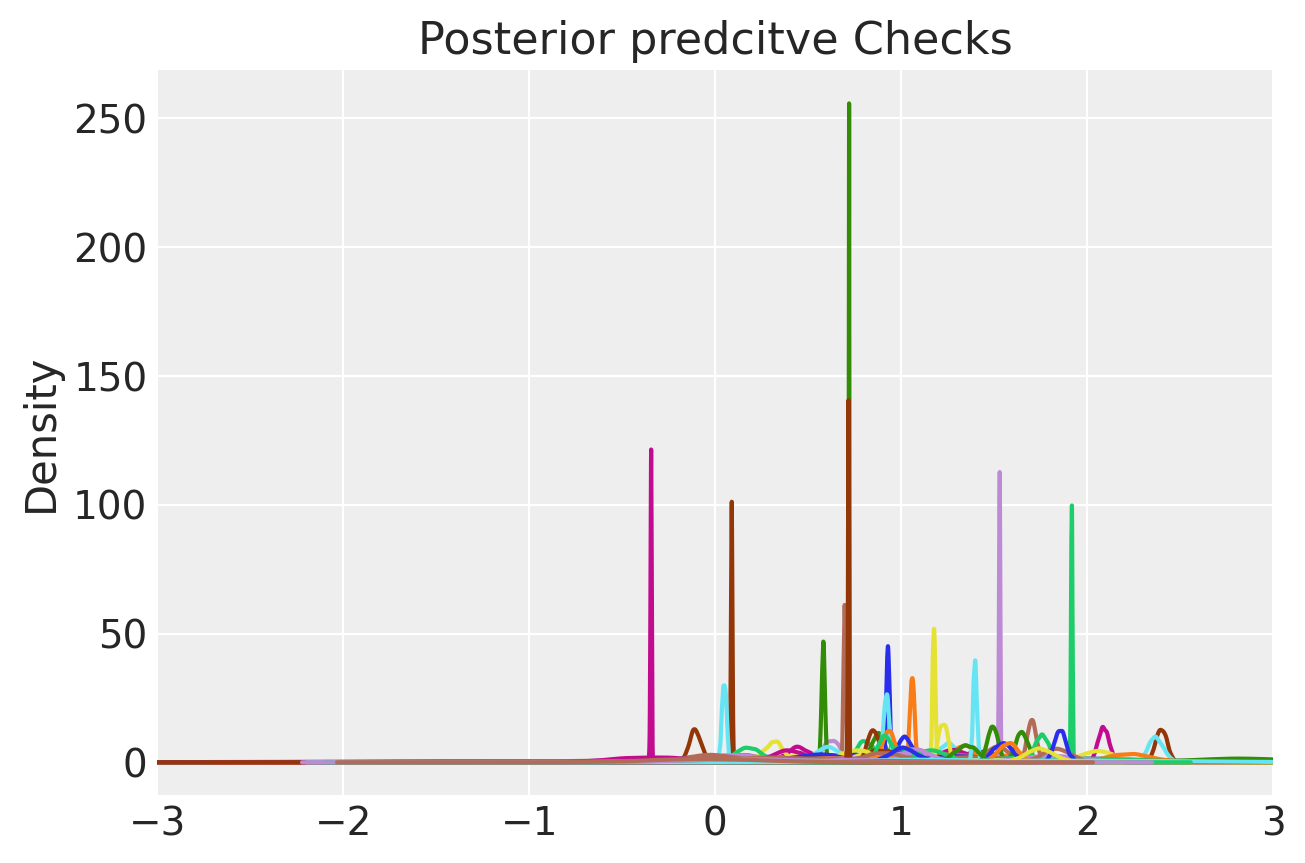

In [482]:
ols_df.filter(regex = 'y_hat').T.iloc[:, :500].plot.kde(legend = False,
                                                        xlim = (-10, 10), title = 'Posterior predcitve Checks');

In [362]:
np.exp(ols_df.filter(regex = 'y_hat').T.mean(axis=1))

y_hat[1]       2.579083
y_hat[2]       2.698954
y_hat[3]       2.599195
y_hat[4]       2.741799
y_hat[5]       2.663459
                 ...   
y_hat[1456]    2.646529
y_hat[1457]    2.714772
y_hat[1458]    2.781792
y_hat[1459]    2.706060
y_hat[1460]    2.783306
Length: 1460, dtype: float64

In [367]:
ols_df.filter(regex = 'y_hat').T.iloc[:, :500]

0         1         2         3         4         5  \
y_hat[1]     1.081826  3.931340  1.251928  0.347516 -2.818177  0.552395   
y_hat[2]     1.313081  0.217038  0.479006  1.678477 -0.765607  3.537516   
y_hat[3]     1.129563 -1.138551 -0.340555  0.400983 -2.935219  0.352242   
y_hat[4]     0.538489 -0.531597 -0.831752  1.514874 -0.153508  1.714361   
y_hat[5]     2.420251 -2.735226 -0.716740  2.640960 -4.321104  2.800099   
...               ...       ...       ...       ...       ...       ...   
y_hat[1456]  0.380992  2.354086 -2.449099  1.264917  3.752424  3.079092   
y_hat[1457]  1.694499 -1.888524  0.315401  1.378559 -0.482638 -1.276064   
y_hat[1458]  1.360610 -0.916746  4.172453  1.250336 -3.928512 -0.398559   
y_hat[1459]  1.426594 -2.953913 -0.508626  1.229429  2.209746  0.240649   
y_hat[1460]  0.997194 -1.943450  2.922428  1.079588 -0.354656  2.753654   

                    6         7         8         9        10        11  \
y_hat[1]    -0.499478  0.742210  3.158840  0.124328  1.292168 -0.154155   
y_hat[2]     0.092453  0.551462  2.060072  0.700844  0.279021  0.776798   
y_hat[3]     6.524449  1.236657  1.979714  0.803491 -1.220873 -1.726741   
y_hat[4]     3.123338  0.952881  1.999094  0.446932 -0.549226  1.406433   
y_hat[5]    -0.267206  0.820165  3.589338  1.904376  3.626069  2.964388   
...               ...       ...       ...       ...       ...       ...   
y_hat[1456]  1.396232  0.682657  1.842892  0.309144 -2.402244  1.534059   
y_hat[1457]  0.243168  1.181069  2.062315  1.132019 -1.401918  0.916503   
y_hat[1458]  1.474789  0.562693  2.769655  1.045360 -0.594305 -0.002799   
y_hat[1459]  3.987524  1.135771  1.035469  0.746121  4.389592  0.861425   
y_hat[1460] -1.683047  0.560216  0.557944  1.092336  0.632417  0.788933   

                   12        13        14        15        16        17  \
y_hat[1]     1.227506 -0.178395  0.689884  0.323392  1.425935 -0.032053   
y_hat[2]    -0.720996 -0.223995 -0.313212  2.092571  2.336927  1.191150   
y_hat[3]    -0.702485  0.873868 -1.078994  1.108128  1.090224 -0.590268   
y_hat[4]     1.700529  0.141054  2.564286  0.807562  2.048015 -1.179347   
y_hat[5]     0.642067 -0.599666  0.624637  2.385296  1.330526 -0.476580   
...               ...       ...       ...       ...       ...       ...   
y_hat[1456]  0.417668 -0.135003  0.489963  0.723982  2.251269  0.259630   
y_hat[1457]  0.606719  0.302752  0.480435  1.264425  0.885245 -0.950992   
y_hat[1458]  2.036319  0.814855  1.231026  1.732369  1.138642 -3.094021   
y_hat[1459]  2.019500  1.249091 -1.069612  1.020036  2.661872 -0.783852   
y_hat[1460]  3.352888  0.831993  0.835362  1.197465  2.313644  2.352661   

                   18        19        20        21        22        23  \
y_hat[1]     1.566817  1.055663 -2.995586  0.292042 -1.554202  1.278843   
y_hat[2]     0.545811  0.833402 -1.588122 -0.200083  4.442895  1.718075   
y_hat[3]     1.203081  0.939690  1.851242  0.503764 -2.966485  0.957890   
y_hat[4]    -0.670195  1.047506  2.100646  0.436808 -1.244576  1.418540   
y_hat[5]     4.258174  1.004070  1.893116  0.345729  0.816781  0.919303   
...               ...       ...       ...       ...       ...       ...   
y_hat[1456] -1.123029  0.614094 -0.154408  0.035992 -1.562088  2.073827   
y_hat[1457]  1.066272  1.250260  1.386803  0.185223 -2.371363  0.750198   
y_hat[1458] -3.345893  0.693812  4.204307  0.087346 -1.094240  1.478164   
y_hat[1459] -0.291145  0.718841  2.106920  0.308141 -1.844870  1.436223   
y_hat[1460] -0.884547  0.621575 -3.304118  0.534069  1.212655  1.271146   

                   24        25        26        27        28        29  \
y_hat[1]     1.028064  1.562826  2.185973 -4.242221  0.501987  1.118078   
y_hat[2]     0.524110  1.422410  1.147572 -0.562125 -1.592156  1.292679   
y_hat[3]     1.531036  1.538154  1.526678 -2.916508 -5.253745  1.241371   
y_hat[4]     0.162029  1.223295  4.567415  4.547892  0.346616  1.396331   
y_hat[5]     1.326673  1.200631  8.576602

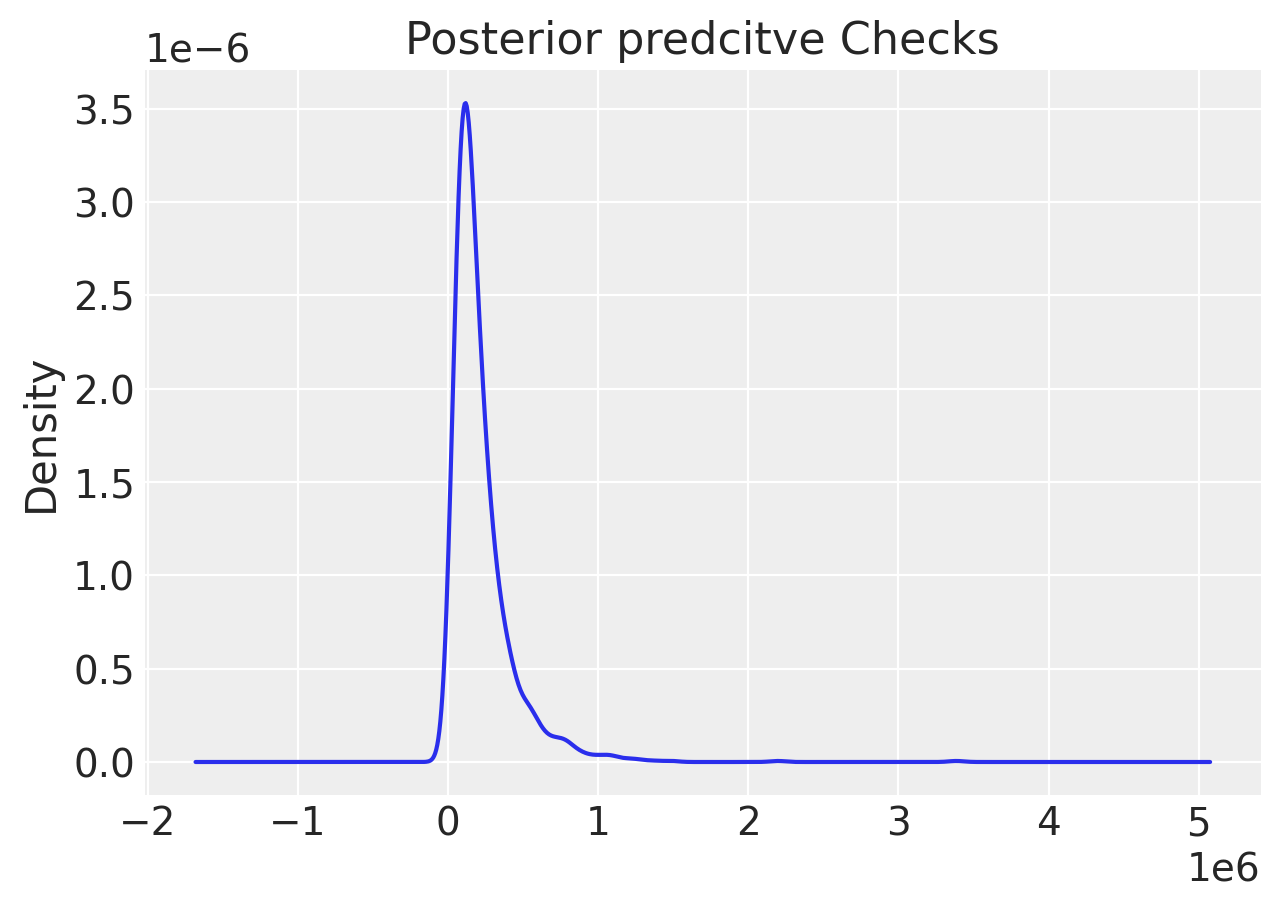

In [379]:
np.exp((ols_df.filter(regex = 'y_hat').T.iloc[:, :500]*df['log_sales_price'].mean()).mean(axis=1)).plot.kde(legend = False, title = 'Posterior predcitve Checks');

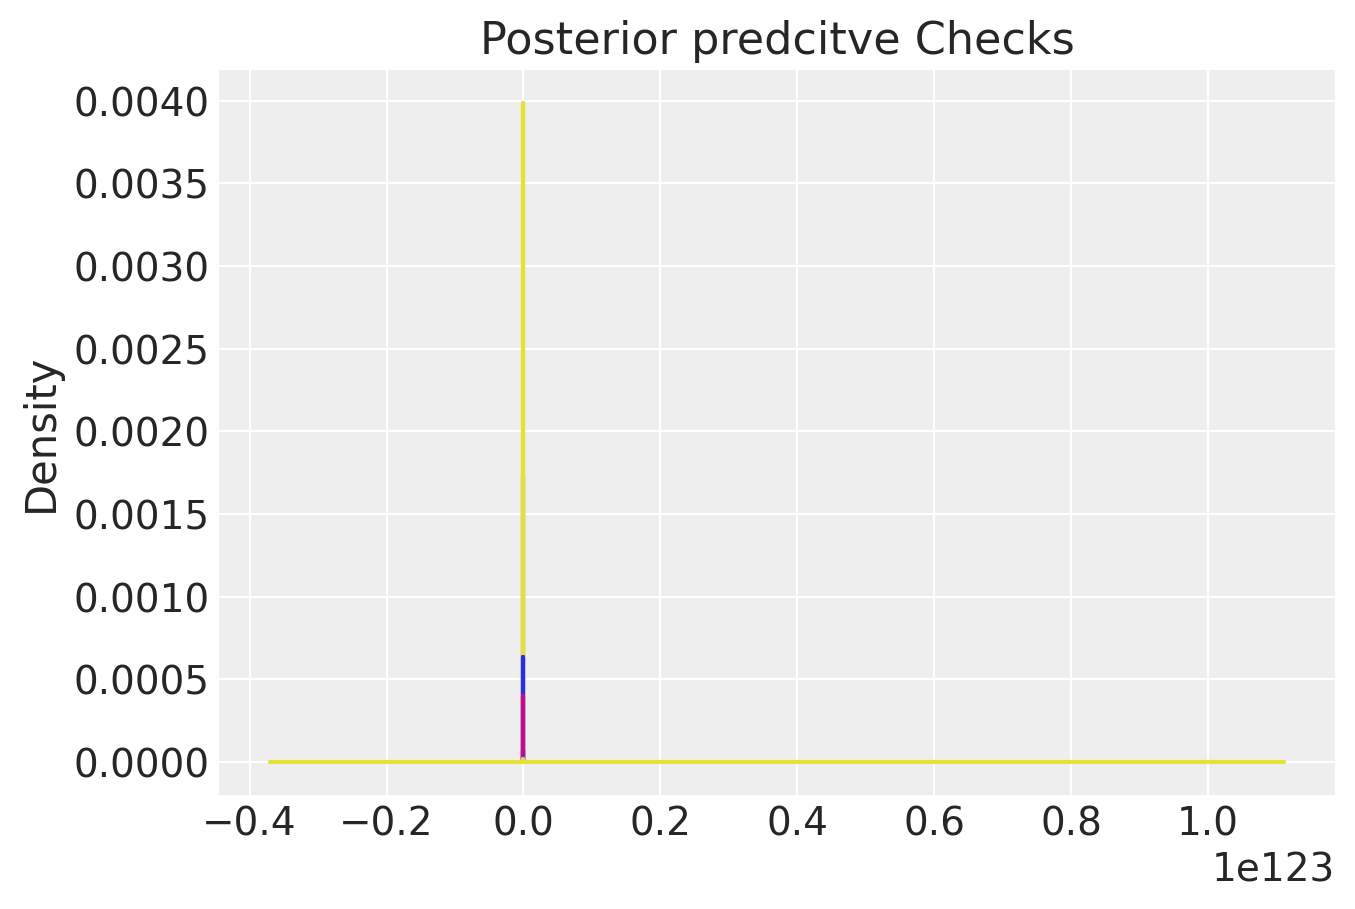

In [380]:
np.exp(ols_df.filter(regex = 'y_hat')\
             .T\
             .iloc[:, :500]*df['log_sales_price'].mean()).plot.kde(legend = False, title = 'Posterior predcitve Checks');

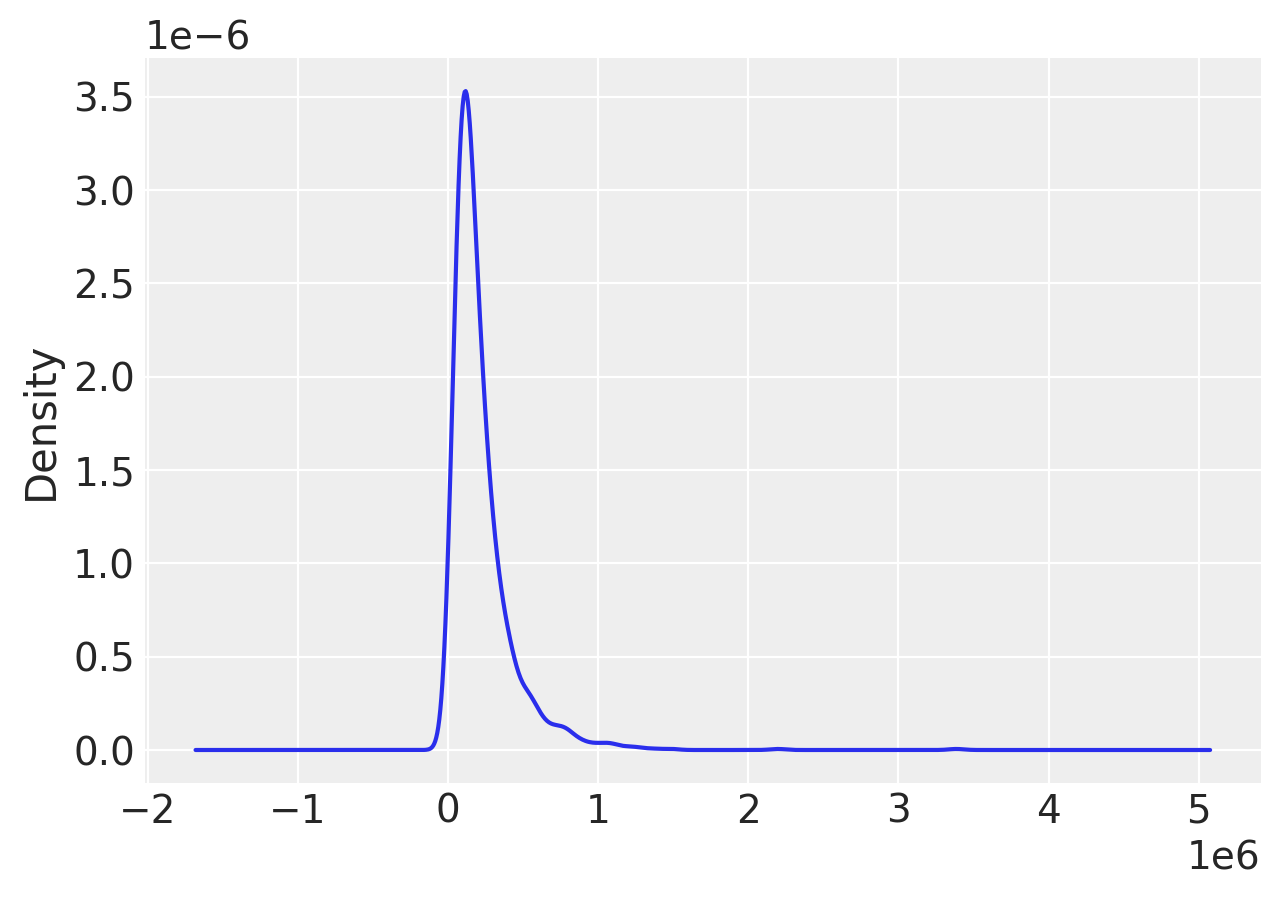

In [390]:
np.exp((ols_df.filter(regex = 'y_hat')\
             .T\
             .iloc[:, :500]*df['log_sales_price'].mean()).mean(axis=1)).plot.kde()

In [386]:
np.exp(ols_df.filter(regex = 'y_hat')\
             .T\
             .iloc[:, :500]*df['log_sales_price'].mean())

0                        1  \
y_hat[1]           445934.10 338356810875472576512.00   
y_hat[2]          7192511.72                    13.59   
y_hat[3]           791683.60                     0.00   
y_hat[4]              648.60                     0.00   
y_hat[5]    4350102160488.38                     0.00   
...                      ...                      ...   
y_hat[1456]            97.62         1963301746583.14   
y_hat[1457]     705730281.90                     0.00   
y_hat[1458]      12737277.78                     0.00   
y_hat[1459]      28160725.02                     0.00   
y_hat[1460]        161184.95                     0.00   

                                    2                 3  \
y_hat[1]                   3447798.36             65.27   
y_hat[2]                       317.22      582068605.45   
y_hat[3]                         0.02            124.14   
y_hat[4]                         0.00       81403430.42   
y_hat[5]                         0.00 61806788398271.09   
...                               ...               ...   
y_hat[1456]                      0.00        4030585.94   
y_hat[1457]                     44.36       15805346.79   
y_hat[1458] 6144139924477921198080.00        3382427.06   
y_hat[1459]                      0.00        2630585.06   
y_hat[1460]       1823296532439168.00         434096.63   

                                  4                      5  \
y_hat[1]                       0.00                 766.65   
y_hat[2]                       0.00 2970529552236845056.00   
y_hat[3]                       0.00                  69.09   
y_hat[4]                       0.16           896103046.11   
y_hat[5]                       0.00     418849051436317.50   
...                             ...                    ...   
y_hat[1456] 39362171206819749888.00   11993727617577796.00   
y_hat[1457]                    0.00                   0.00   
y_hat[1458]                    0.00                   0.01   
y_hat[1459]         346137288314.28                  18.06   
y_hat[1460]                    0.01     239620723911843.94   

                                                 6          7  \
y_hat[1]                                      0.00    7512.89   
y_hat[2]                                      3.04     758.09   
y_hat[3]    11763493408807155378588081669013504.00 2869451.78   
y_hat[4]                      20417674851283484.00   94607.20   
y_hat[5]                                      0.04   19181.51   
...                                            ...        ...   
y_hat[1456]                            19547639.26    3671.29   
y_hat[1457]                                  18.61 1470672.62   
y_hat[1458]                            50270696.24     867.70   
y_hat[1459]               664916298438234603520.00  853046.46   
y_hat[1460]                                   0.00     842.24   

                                 8             9                         10  \
y_hat[1]      31289367480646620.00          4.46                 5593410.48   
y_hat[2]            57233654002.17       4568.72                      28.64   
y_hat[3]            21778429886.20      15696.86                       0.00   
y_hat[4]            27493211464.33        215.71                       0.00   
y_hat[5]    5539183212582222848.00 8802608272.31     8614979852621609984.00   
...                            ...           ...                        ...   
y_hat[1456]          4202858926.77         41.15                       0.00   
y_hat[1457]         58798267159.86     815416.78                       0.00   
y_hat[1458]     290456320631503.94     287639.21                       0.00   
y_hat[1459]              255386.53       7874.57 83629330791720909012992.00   
y_hat[1460]                 819.54     506005.11                    2006.63   

                             11                    12         13  \
y_hat[1]                   0.16            2570444.93       0.12   
y_hat[2]              

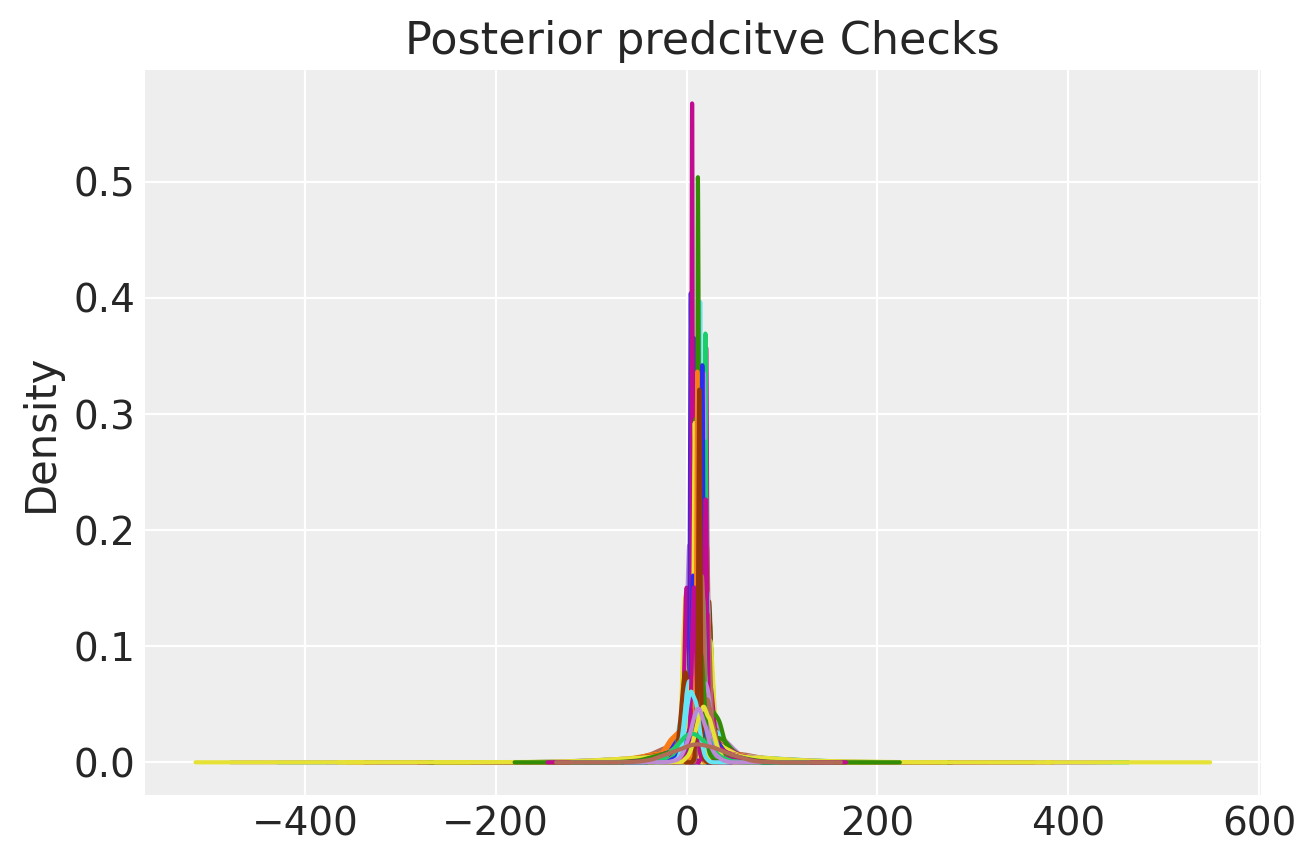

In [384]:
pd.set_option('display.float_format', '{:.2f}'.format)
(ols_df.filter(regex = 'y_hat')\
             .T\
             .iloc[:, :500]*df['log_sales_price'].mean()).plot.kde(legend = False, title = 'Posterior predcitve Checks');

In [359]:
df['SalePrice'].head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [ ]:
df['log_sales_price_std'] = df['log_sales_price']/df['log_sales_price'].mean()

In [360]:
np.exp(df['log_sales_price_std'] * df['log_sales_price'].mean())

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
1455    175000.0
1456    210000.0
1457    266500.0
1458    142125.0
1459    147500.0
Name: log_sales_price_std, Length: 1460, dtype: float64